# 电信客户流失预测分析

## 0、概览

**数据包含6043条记录，21个特征：**

|序号|字段名|数据类型|字段描述|
|--|--|--|--|
|1	|customerID	|String	|顾客ID|
|2	|gender	|String	|无论客户是男性还是女性
|3	|SeniorCitizen	|Integer|	客户是否为老年人（1,0）|
|4	|Partner	|String|	客户是否有配偶（是，否）|
|5	|Dependents	|String	|客户是否有家属（是，否）|
|6	|tenure	|Integer	|客户在公司停留的月数|
|7	|PhoneService	|String	|客户是否有电话服务（是，否）|
|8	|MultipleLines	|String	|客户是否有多条线路（是，否，没有电话服务）|
|9	|InternetService|	String	|客户的互联网服务提供商（DSL，光纤，否）|
|10	|OnlineSecurity	|String	|客户是否具有在线安全性（是，否，没有互联网服务）|
|11	|OnlineBackup	|String	|客户是否有在线备份（是，否，没有互联网服务）|
|12	|DeviceProtection|	String	|客户是否有设备保护（是，否，没有互联网服务）|
|13	|TechSupport|	String	|客户是否有技术支持（是，否，没有互联网服务）|
|14	|StreamingTV	|String	|客户是否有流媒体电视（是，否，没有互联网服务）|
|15	|StreamingMovies	|String	|客户是否有流媒体电影（是，否，没有互联网服务）|
|16	|Contract|	String	|客户的合同期限（每月，一年，两年）|
|17	|PaperlessBilling	|String	|客户是否有无纸化账单（是，否）|
|18	|PaymentMethod|	String	|客户的付款方式（电子支票，邮寄支票，银行转帐（自动），信用卡（自动））|
|19	|MonthlyCharges|	Integer	|每月向客户收取的金额|
|20	|TotalCharges	|Integer	|向客户收取的总金额|
|21	|Churn|	String	|客户是否流失（是或否）|

**特征主要包含如下信息：**

- **客户属性信息：** gender, SeniorCitizen, Partner, Dependents, 
- **签约服务：** PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
- **账户信息：** customerID, tenure, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges
- **流失特征：** Churn

**流失主要原因:**

- 产品
- 公司
- 竞品
- ...

**建模目标:**
- 通过预测模型，给出客户可能流失名单
- 根据特征分析给出客户留存策略

**实施流程:**
- 数据清洗与探索
- 特征工程与选择
- 模型选择与参数调整
- 模型评估


## 1、数据准备

#### 导入资源

In [33]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts.charts import Bar, Pie
from pyecharts import options as opts 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from mlxtend.classifier import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')
sns.set()
mpl.rcParams['font.family'] = 'SimHei'

#### 加载数据

In [34]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path,  'data')
pic_path = os.path.join(root_path, 'picture')
model_path = os.path.join(root_path, 'model')

In [35]:
file_name = os.path.join(data_path,'train.csv')
data = pd.read_csv(file_name)

In [36]:
data.sample(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2878,0428-IKYCP,Male,0,Yes,No,22,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),87.0,1850.65,No
3892,3824-RHKVR,Female,0,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.7,340.35,No


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6043 entries, 0 to 6042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6043 non-null   object 
 1   gender            6043 non-null   object 
 2   SeniorCitizen     6043 non-null   int64  
 3   Partner           6043 non-null   object 
 4   Dependents        6043 non-null   object 
 5   tenure            6043 non-null   int64  
 6   PhoneService      6043 non-null   object 
 7   MultipleLines     6043 non-null   object 
 8   InternetService   6043 non-null   object 
 9   OnlineSecurity    6043 non-null   object 
 10  OnlineBackup      6043 non-null   object 
 11  DeviceProtection  6043 non-null   object 
 12  TechSupport       6043 non-null   object 
 13  StreamingTV       6043 non-null   object 
 14  StreamingMovies   6043 non-null   object 
 15  Contract          6043 non-null   object 
 16  PaperlessBilling  6043 non-null   object 


多数特征为**字符型**变量，少数为**数值型**变量，发现**TotalCharges**数据类型为object，不正确需要进行修正

In [38]:
# TotalCharges 数据类型错误，转为float
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

**查看缺失情况**

In [39]:
# 查看缺失值情况
data.isnull().sum().sort_values(ascending=False).reset_index().rename(columns={'index':'Variable', 0:'Count'})

,Variable,Count
0,TotalCharges,9
1,Churn,0
2,OnlineSecurity,0
3,gender,0
4,SeniorCitizen,0
5,Partner,0
6,Dependents,0
7,tenure,0
8,PhoneService,0
9,MultipleLines,0


In [40]:
# 查看TotalCharges缺失的情况
data[data['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


客户停留月数为0，即为新户，考虑将tenure=0赋值为1，TotalCharges赋值为MonthlyCharges

In [41]:
data.loc[data['tenure']==0, 'tenure'] = 1
data['TotalCharges'] = np.where(data['TotalCharges'].isnull(), data['MonthlyCharges'], data['TotalCharges'])

#### Tools

In [42]:
def bar_plot(data, feature, title):
    yes = data[data['Churn']=='Yes'][feature].value_counts().to_dict()
    no = data[data['Churn']=='No'][feature].value_counts().to_dict()

    bar = Bar()
    bar.add_xaxis(list(yes.keys()))
    bar.add_yaxis("Churn=Yes", list(yes.values()))
    bar.add_yaxis("Churn=No", list(no.values()))
    bar.set_global_opts(title_opts=opts.TitleOpts(title=title))
    return bar

def plot_confusion_matrix(clf, x, y, classes, x_test=None, y_test=None, title='Confustion Matrix', cmap=plt.cm.Blues):
    
    pred = clf.predict(x)
    cm = confusion_matrix(y, pred)
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicated label')
    if y_test is not None:
        pred_test = clf.predict(x_test)
        cm_test = confusion_matrix(y_test, pred_test)
        plt.subplot(1, 2, 2)
        plt.imshow(cm_test, interpolation='nearest', cmap=cmap)
        plt.title('Confustion Matrix —— Test')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)

        thresh = cm_test.max() / 2
        for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
            plt.text(j, i, cm_test[i, j], horizontalalignment='center', color='white' if cm_test[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicated label')
    
def plot_roc_curve(clf, x, y, x_test, y_test=None, model=None):
    """
    ROC AUC
    @params:
    
    """
    plt.figure(figsize=(14, 6))
    pred_proba = clf.predict_proba(x)[:,1]
    fpr,tpr,thresholds = roc_curve(y, pred_proba)
    plt.subplot(1, 2, 1)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="blue")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
    if y_test is not None:
        pred_proba_test = clf.predict_proba(x_test)[:,1]
        fpr,tpr,thresholds = roc_curve(y_test, pred_proba_test)
        plt.subplot(1, 2, 2)
        plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
        plt.plot([1,0],[1,0],linestyle = "dashed",color ="blue")
        plt.legend(loc = "best")
        plt.title("ROC - CURVE & AREA UNDER CURVE —— Test",fontsize=20)


def print_result(clf, x, y=None, data='训练集'):
    print ("*****************************************************************************************")
    print ("MODEL - OUTPUT: {name}".format(name=data))
    print ("*****************************************************************************************")
    pred = clf.predict(x)
    
    print ("\naccuracy_score :",accuracy_score(y, pred))
    
    print ("\nclassification report :\n",(classification_report(y, pred)))
    
def plot_feature_importance(clf, x, of_type='feat'):
    
    plt.figure(figsize=(12, 6))
    
    if  of_type == "feat":
        dataframe = pd.DataFrame(clf.feature_importances_, x.columns).reset_index()
    else:
        dataframe = pd.DataFrame(clf.coef_.ravel(), x.columns).reset_index()
        
    dataframe = dataframe.rename(columns={"index":"features",0:"coefficients"})
    dataframe = dataframe.sort_values(by="coefficients",ascending = False)
    ax = sns.barplot(x = "coefficients" ,y ="features",data=dataframe,palette="husl")
    plt.title("FEATURE IMPORTANCES",fontsize =20)
    for i,j in enumerate(dataframe["coefficients"]):
        ax.text(.011,i,j,weight = "bold")
    plt.show()

## 2、数据探索
从客户属性、订阅服务、账户信息三个方向分析流失情况

### 2.1 流失分布情况

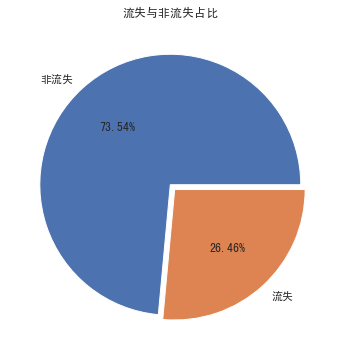

In [44]:
# 流失情况
churn = data['Churn'].value_counts(normalize=True).to_dict()
# pie = Pie()
# pie.add("", [(key, value) for key, value in churn_rate.items()])
# pie.set_global_opts(title_opts=opts.TitleOpts(title="电信客户流失情况"))
# pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))

plt.figure(figsize=(6, 6))  
plt.pie(
    churn.values(),   
    labels=['非流失', '流失'],   
    explode=[0, 0.05],   
    autopct='%1.2f%%',   
    )
plt.title('流失与非流失占比') 
plt.savefig(pic_path + '/总体流失.png')
plt.show()   

数据有轻微的不平衡，可以考虑进行采样处理，同时选择F1-Score作为评价标准，或者以商业目标为准则

### 2.2 客户属性信息
gender, SeniorCitizen, Partner, Dependents

#### 2.2.1 性别情况

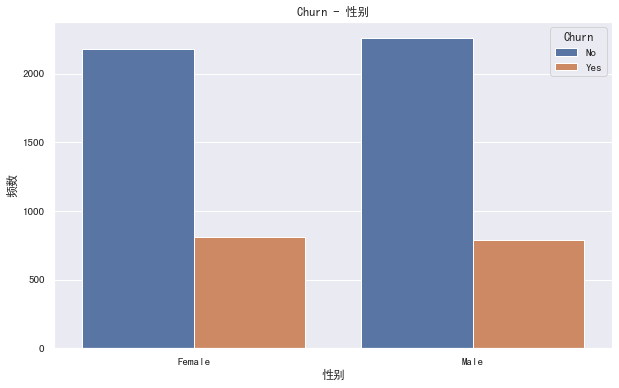

In [45]:
# bar = Bar()
# bar.add_xaxis(list(yes.keys()))
# bar.add_yaxis("Churn=Yes", list(yes.values()))
# bar.add_yaxis("Churn=No", list(no.values()))
# bar.set_global_opts(title_opts=opts.TitleOpts(title="性别分布情况"))
# bar.render_notebook()

fig = plt.figure(figsize=(10, 6))

ax = sns.countplot(x='gender', data=data, hue='Churn', hue_order=['No', 'Yes'])
ax.set(xlabel='性别', ylabel='频数', title='Churn - 性别')
plt.savefig(pic_path + '/性别流失情况.png')

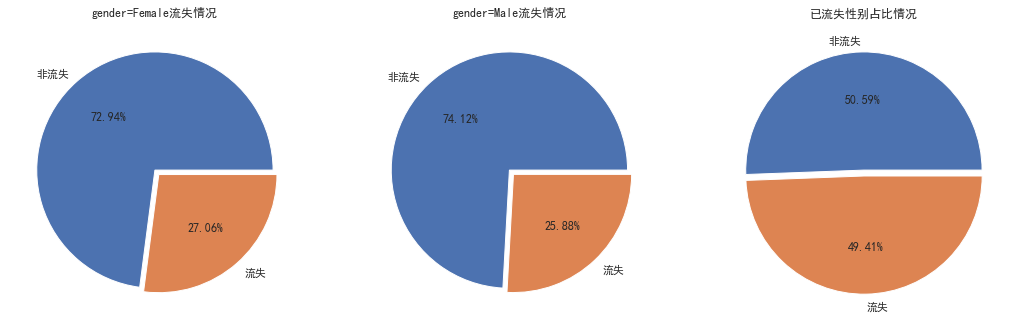

In [12]:
# 性别流失比例
churn_female = data[data['gender']=='Female']['Churn'].value_counts(normalize=True).to_dict()
churn_male = data[data['gender']=='Male']['Churn'].value_counts(normalize=True).to_dict()
churn = data[data['Churn']=='Yes']['gender'].value_counts(normalize=True).to_dict()


# pie = Pie()
# pie.add("", [(key, value) for key, value in churn_rate.items()])
# pie.set_global_opts(title_opts=opts.TitleOpts(title="gender=Female流失情况"))
# pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
# pie.render_notebook()
plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
plt.pie(
    churn_female.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('gender=Female流失情况')  

plt.subplot(1, 3, 2)
plt.pie(
    churn_male.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('gender=Male流失情况') 

plt.subplot(1, 3, 3)
plt.pie(
    churn.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05], 
    autopct='%1.2f%%',  
    )
plt.title('已流失性别占比情况')  
plt.show()  

#### 2.2.2 年龄

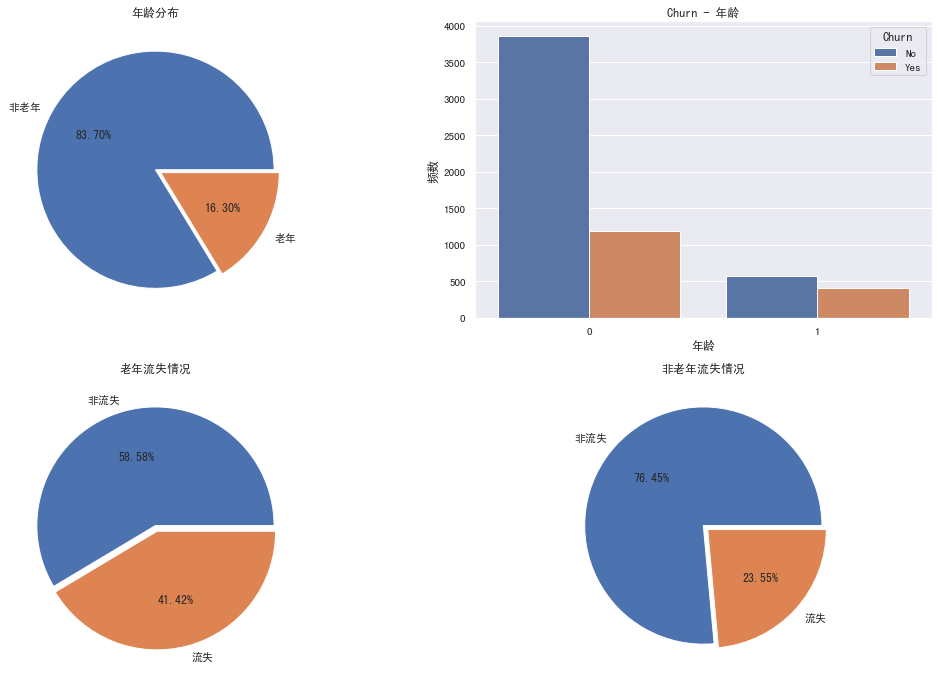

In [48]:
# 年龄分布占比
rate = data['SeniorCitizen'].map({1:'老年', 0: '非老年'}).value_counts(normalize=True).to_dict()
churn_1 = data[data['SeniorCitizen']==1]['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['SeniorCitizen']==0]['Churn'].value_counts(normalize=True).to_dict()

plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.pie(
    rate.values(),  
    labels=['非老年', '老年'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%', 
    )
plt.title('年龄分布')  

plt.subplot(2, 2, 2)
ax = sns.countplot(x='SeniorCitizen', data=data, hue='Churn', hue_order=['No', 'Yes'])
ax.set(xlabel='年龄', ylabel='频数', title='Churn - 年龄')

plt.subplot(2, 2, 3)
plt.pie(
    churn_1.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('老年流失情况')  

plt.subplot(2, 2, 4)
plt.pie(
    churn_0.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('非老年流失情况')  
plt.savefig(pic_path + "/年龄流失情况.png")
plt.show()  

**年龄和性别分布**

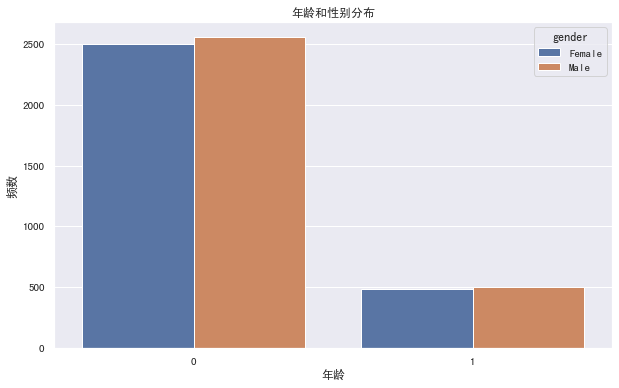

In [47]:
# age = data.groupby(['gender', 'SeniorCitizen'])['customerID'].count().reset_index().rename(columns={'customerID':'value'})
# age = pd.pivot_table(age, columns='gender', index='SeniorCitizen', values='value')
# age.index = ['非老年', '老年']
# fem = age['Female'].to_dict()
# mal = age['Male'].to_dict()
fig = plt.figure(figsize=(10, 6))

ax = sns.countplot(x='SeniorCitizen', data=data, hue='gender', hue_order=['Female', 'Male'])
ax.set(xlabel='年龄', ylabel='频数', title='年龄和性别分布')
plt.savefig(pic_path + '/年龄和性别分布.png')

#### 伴侣情况

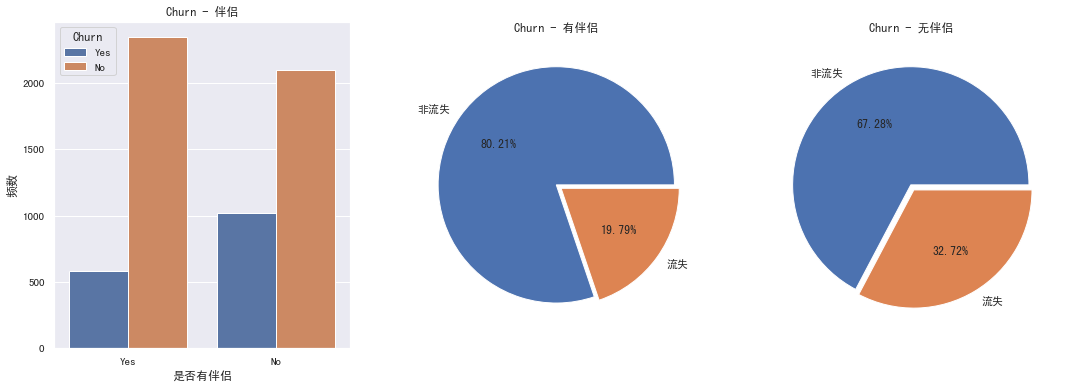

In [52]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
ax = sns.countplot(x='Partner', data=data, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='是否有伴侣', ylabel='频数', title='Churn - 伴侣')

# 性别流失比例
churn_rate = data[data['Partner']=='Yes']['Churn'].value_counts(normalize=True).to_dict()

churn_1 = data[data['Partner']=='Yes']['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['Partner']=='No']['Churn'].value_counts(normalize=True).to_dict()

plt.subplot(1, 3, 2)
plt.pie(
    churn_1.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('Churn - 有伴侣')  

plt.subplot(1, 3, 3)
plt.pie(
    churn_0.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('Churn - 无伴侣')  
plt.savefig(pic_path + '/是否有伴侣流失情况.png')

plt.show()  

**亲属情况**

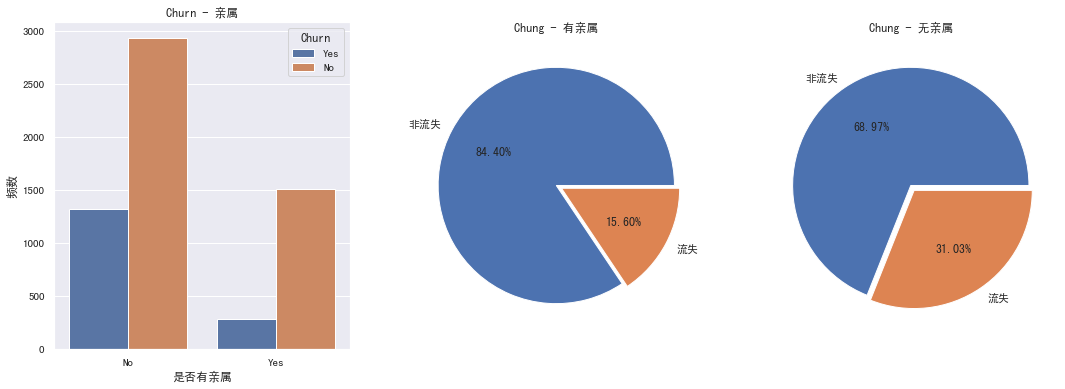

In [53]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
ax = sns.countplot(x='Dependents', data=data, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='是否有亲属', ylabel='频数', title='Churn - 亲属')

# 性别流失比例
churn_1 = data[data['Dependents']=='Yes']['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['Dependents']=='No']['Churn'].value_counts(normalize=True).to_dict()

plt.subplot(1, 3, 2)
plt.pie(
    churn_1.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('Chung - 有亲属')  

plt.subplot(1, 3, 3)
plt.pie(
    churn_0.values(),  
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('Chung - 无亲属')  

plt.savefig(pic_path + '/是否有亲属流失情况.png')

plt.show()  

#### 性别无差异，老年人、无亲属、无伴侣更容易成为流失客户

### 2.3 账户信息
#### 2.3.1 签约合同类型

In [17]:
# yes = data[data['Churn']=='Yes']['Contract'].value_counts().to_dict()
# no = data[data['Churn']=='No']['Contract'].value_counts().to_dict()

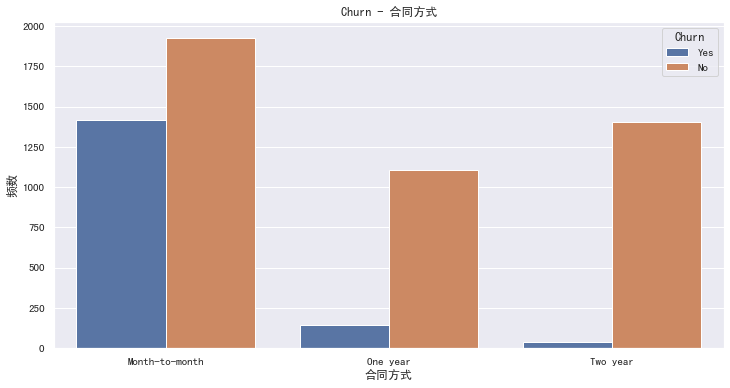

In [54]:
# bar = Bar()
# bar.add_xaxis(list(yes.keys()))
# bar.add_yaxis("Churn=Yes", list(yes.values()))
# bar.add_yaxis("Churn=No", list(no.values()))
# bar.set_global_opts(title_opts=opts.TitleOpts(title="合同方式流失情况"))
# bar.render_notebook()

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Contract', data=data, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='合同方式', ylabel='频数', title='Churn - 合同方式')
plt.savefig(pic_path + '/不同合同方式流失情况.png')


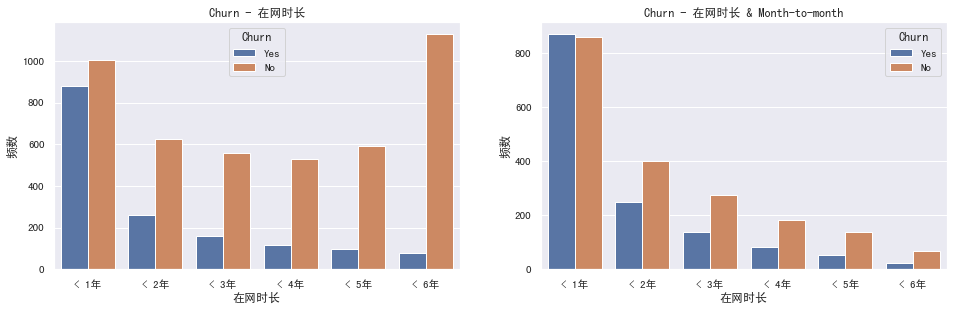

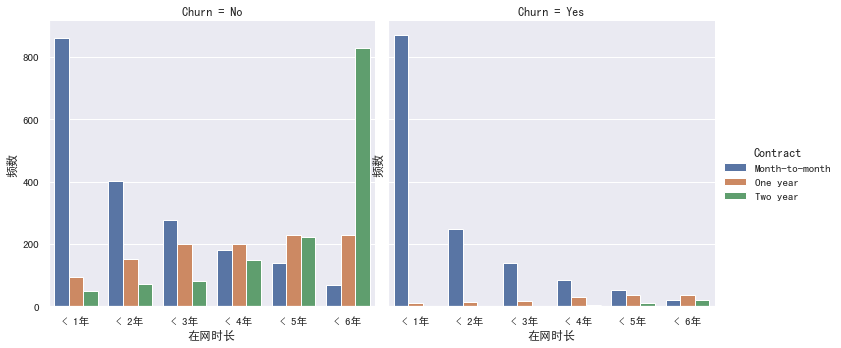

In [55]:
# month-to-month & tenure 分析
data1 = data.copy()
tenure_cut = pd.cut(data['tenure'], 
                    bins=[0, 12, 24, 36, 48, 60, 72], 
                    labels=["< 1年", "< 2年", "< 3年","< 4年","< 5年","< 6年"]).rename('tenure_cut')
data1 = pd.concat([data1, tenure_cut], axis=1)

data2 = data1[data1['Contract']=='Month-to-month']

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
ax = sns.countplot(x='tenure_cut', data=data1, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='在网时长', ylabel='频数', title='Churn - 在网时长')

plt.subplot(2, 2, 2)
ax = sns.countplot(x='tenure_cut', data=data2, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='在网时长', ylabel='频数', title='Churn - 在网时长 & Month-to-month')
#data1.head(2)

#plt.subplot(2, 2, 3)
ax = sns.catplot(x='tenure_cut', data=data1, hue='Contract', col='Churn', kind='count')
ax.set(xlabel='在网时长', ylabel='频数')
plt.savefig(pic_path + '/月付与在网时长情况.png')

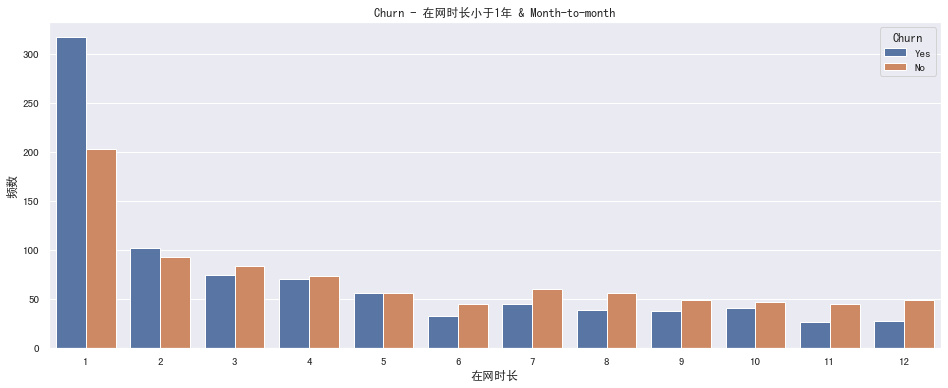

In [57]:
data1 = data[(data['tenure']<=12) & (data['Contract']=='Month-to-month')]
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='tenure', data=data1, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='在网时长', ylabel='频数', title='Churn - 在网时长小于1年 & Month-to-month')
plt.savefig(pic_path + '/在网时长小于1年 & Month-to-month.png')

对于非流失客户，月付和年付方式差距不大；而对于流失客户来看，月付和年付的方式差距较大，通常来说年付客户相对来说不容易流失；同时月付客户前6个月属于流失高峰

继续比较月付的monthly_charges 和total_charges的差别：

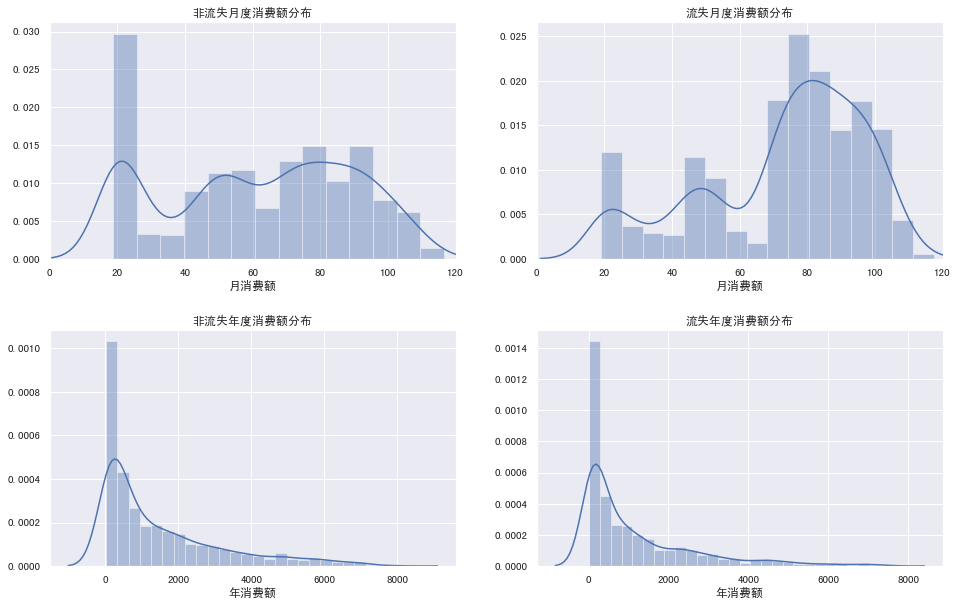

In [60]:
# 
no_m = data[(data['Contract']=='Month-to-month') & (data['Churn']=='No')]['MonthlyCharges']
Yes_m = data[(data['Contract']=='Month-to-month') & (data['Churn']=='Yes')]['MonthlyCharges']

no_t = data[(data['Contract']=='Month-to-month') & (data['Churn']=='No')]['TotalCharges']
Yes_t = data[(data['Contract']=='Month-to-month') & (data['Churn']=='Yes')]['TotalCharges']

plt.figure(figsize=(16,10))
plt.subplot(2, 2, 1)
ax = sns.distplot(no_m, kde=True)
ax.set(title='非流失月度消费额分布', xlabel='月消费额')
plt.xlim(0, 120)

plt.subplot(2, 2, 2)
ax = sns.distplot(Yes_m)
ax.set(title='流失月度消费额分布', xlabel='月消费额')
plt.xlim([0,120])

plt.subplot(2, 2, 3)
ax = sns.distplot(no_t)
ax.set(title='非流失年度消费额分布', xlabel='年消费额')

plt.subplot(2, 2, 4)
ax = sns.distplot(Yes_t)
ax.set(title='流失年度消费额分布', xlabel='年消费额')

plt.subplots_adjust(hspace=0.3)
plt.savefig(pic_path + '/month-to-month消费分布.png')

月付金额过高导致客户流失，或许可以考虑降低整体资费，促成客户年付，实现客户留存

继续查看付款方式的区别：

[Text(0, 0, 'Electronic check'),
 Text(1, 0, 'Mailed check'),
 Text(2, 0, 'Credit card (automatic)'),
 Text(3, 0, 'Bank transfer (automatic)')]

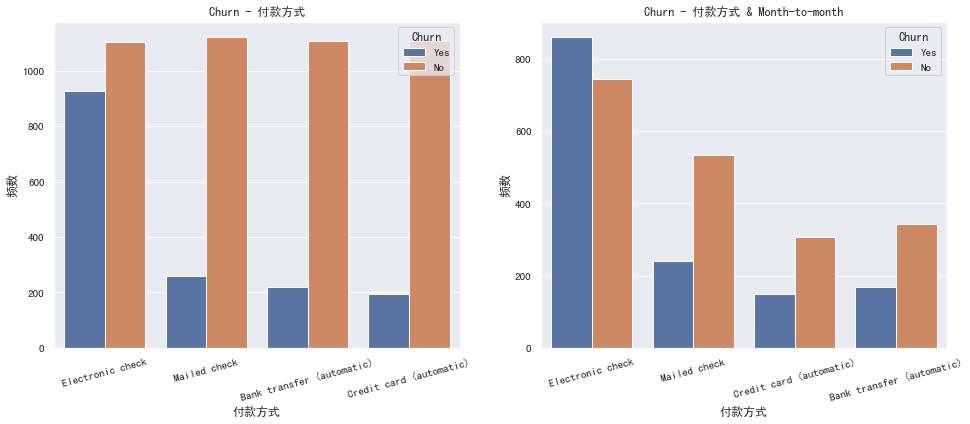

In [61]:
data1 = data[(data['Contract']=='Month-to-month')]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
ax = sns.countplot(x='PaymentMethod', data=data, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='付款方式', ylabel='频数', title='Churn - 付款方式')
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

plt.subplot(1, 2, 2)
ax = sns.countplot(x='PaymentMethod', data=data1, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='付款方式', ylabel='频数', title='Churn - 付款方式 & Month-to-month')
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
plt.savefig(pic_path + '/付款方式消费分布.png')
#data1.head(2)

流失客户更大比例是在Electronic_Check 方式，尝试进行推广自动付款方式

留存月数影响

#### 无纸化

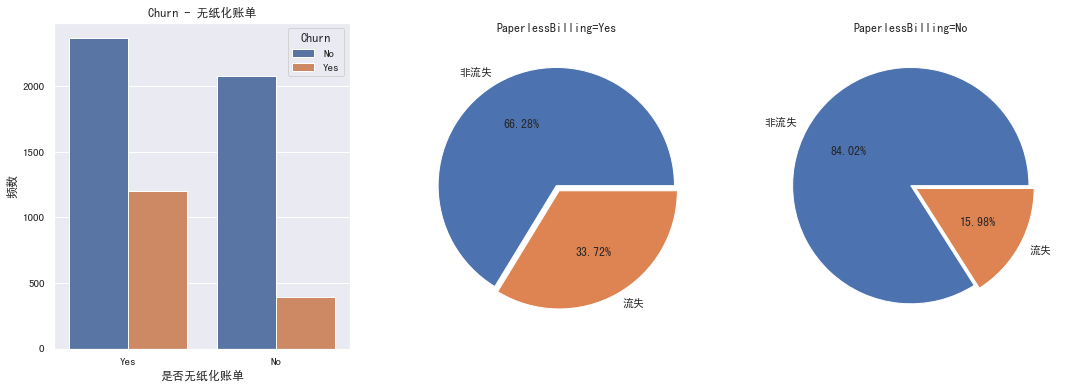

In [71]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)

ax = sns.countplot(x='PaperlessBilling', data=data, hue='Churn', hue_order=['No', 'Yes'])
ax.set(xlabel='是否无纸化账单', ylabel='频数', title='Churn - 无纸化账单')

churn_1 = data[data['PaperlessBilling']=='Yes']['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['PaperlessBilling']=='No']['Churn'].value_counts(normalize=True).to_dict()

plt.subplot(1, 3, 2)
plt.pie(
    churn_1.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05], 
    autopct='%1.2f%%', 
    )
plt.title('PaperlessBilling=Yes') 

plt.subplot(1, 3, 3)
plt.pie(
    churn_0.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('PaperlessBilling=No')  
plt.savefig(pic_path + '/无纸化账单.png')

#### 存续期tenure、月费MonthlyCharges、总费用TotalCharges

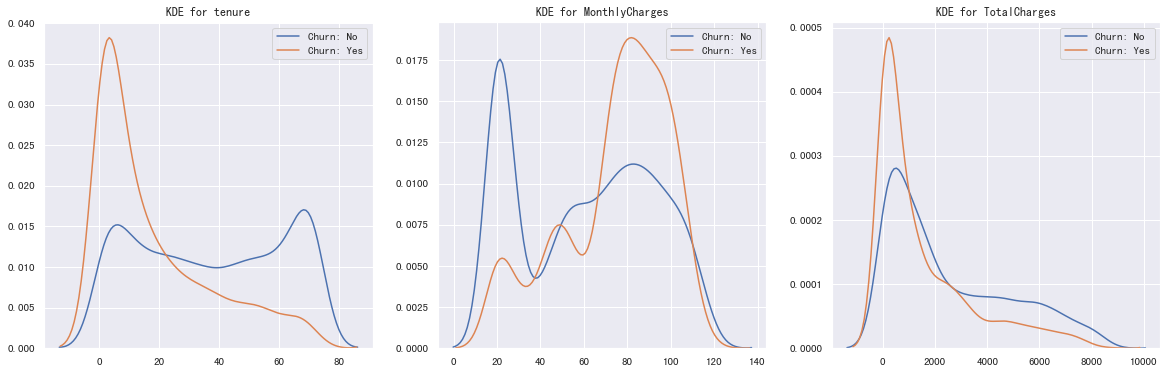

In [76]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
ax1 = sns.kdeplot(data[data['Churn']=='No']['tenure'], label='Churn: No')
ax1 = sns.kdeplot(data[data['Churn']=='Yes']['tenure'], label='Churn: Yes')
plt.title("KDE for tenure")

plt.subplot(1, 3, 2)
ax1 = sns.kdeplot(data[data['Churn']=='No']['MonthlyCharges'], label='Churn: No')
ax1 = sns.kdeplot(data[data['Churn']=='Yes']['MonthlyCharges'], label='Churn: Yes')
plt.title("KDE for MonthlyCharges")

plt.subplot(1, 3, 3)
ax1 = sns.kdeplot(data[data['Churn']=='No']['TotalCharges'], label='Churn: No')
ax1 = sns.kdeplot(data[data['Churn']=='Yes']['TotalCharges'], label='Churn: Yes')
plt.title("KDE for TotalCharges")
plt.savefig(pic_path + '/数值变量kde.png')

月付、在网时长小于6个月、月消费金额高、无纸化账单流失率高

### 2.4 签约服务信息
#### 2.4.1 电话服务

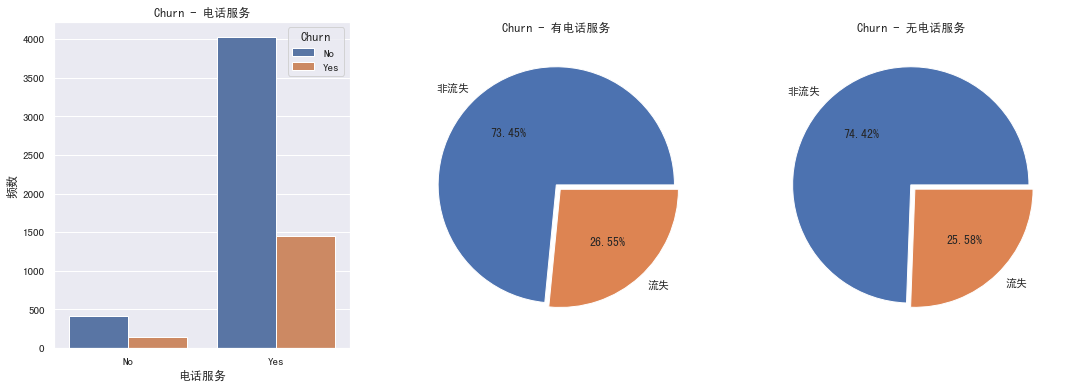

In [70]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)

ax = sns.countplot(x='PhoneService', data=data, hue='Churn', hue_order=['No', 'Yes'])
ax.set(xlabel='电话服务', ylabel='频数', title='Churn - 电话服务')

churn_1 = data[data['PhoneService']=='Yes']['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['PhoneService']=='No']['Churn'].value_counts(normalize=True).to_dict()

plt.subplot(1, 3, 2)
plt.pie(
    churn_1.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05], 
    autopct='%1.2f%%', 
    )
plt.title('Churn - 有电话服务') 

plt.subplot(1, 3, 3)
plt.pie(
    churn_0.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('Churn - 无电话服务')  
plt.savefig(pic_path + '/电话服务.png')

有无电话服务，流失情况一致

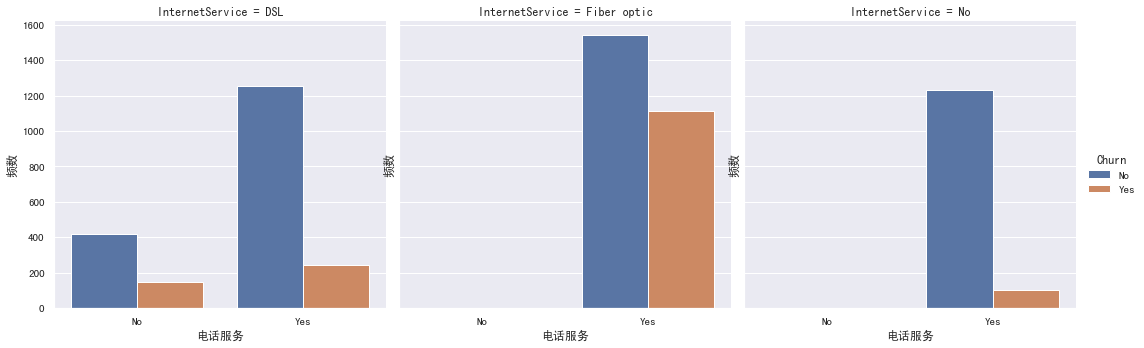

In [74]:
# 电话服务和网络服务情况
ax = sns.catplot(data=data, x='PhoneService', col='InternetService', hue='Churn', kind='count')
ax.set(xlabel='电话服务', ylabel='频数')
plt.savefig(pic_path + '/电话服务与因特网服务分布.png')

#### 2.4.2 多条线路(MultipleLines)

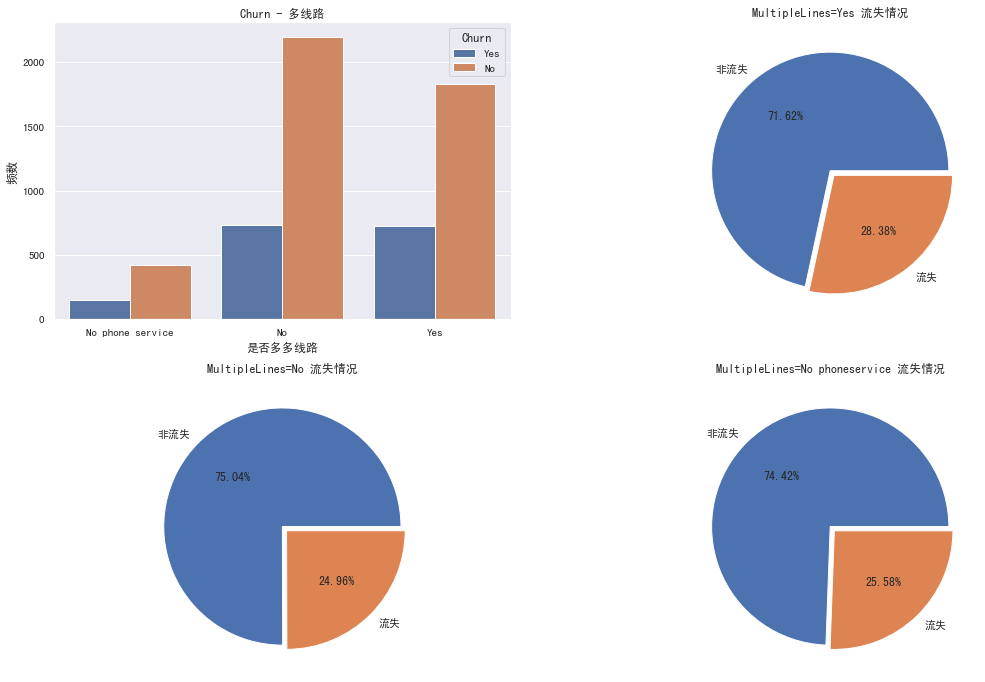

In [75]:
bar = bar_plot(data, 'MultipleLines', '多线路服务')
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)

ax = sns.countplot(x='MultipleLines', data=data, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='是否多多线路', ylabel='频数', title='Churn - 多线路')

churn_1 = data[data['MultipleLines']=='Yes']['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['MultipleLines']=='No']['Churn'].value_counts(normalize=True).to_dict()
churn_2 = data[data['MultipleLines']=='No phone service']['Churn'].value_counts(normalize=True).to_dict()


plt.subplot(2, 2, 2)
plt.pie(
    churn_1.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05], 
    autopct='%1.2f%%', 
    )
plt.title('MultipleLines=Yes 流失情况') 

plt.subplot(2, 2, 3)
plt.pie(
    churn_0.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('MultipleLines=No 流失情况') 

plt.subplot(2, 2, 4)
plt.pie(
    churn_2.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('MultipleLines=No phoneservice 流失情况') 
plt.savefig(pic_path + '/多线路服务.png')

#### 2.4.2 互联网服务
- 有无互联网服务
- 不同服务厂商

Text(0.5, 1.0, 'InternetService=DSL 流失情况')

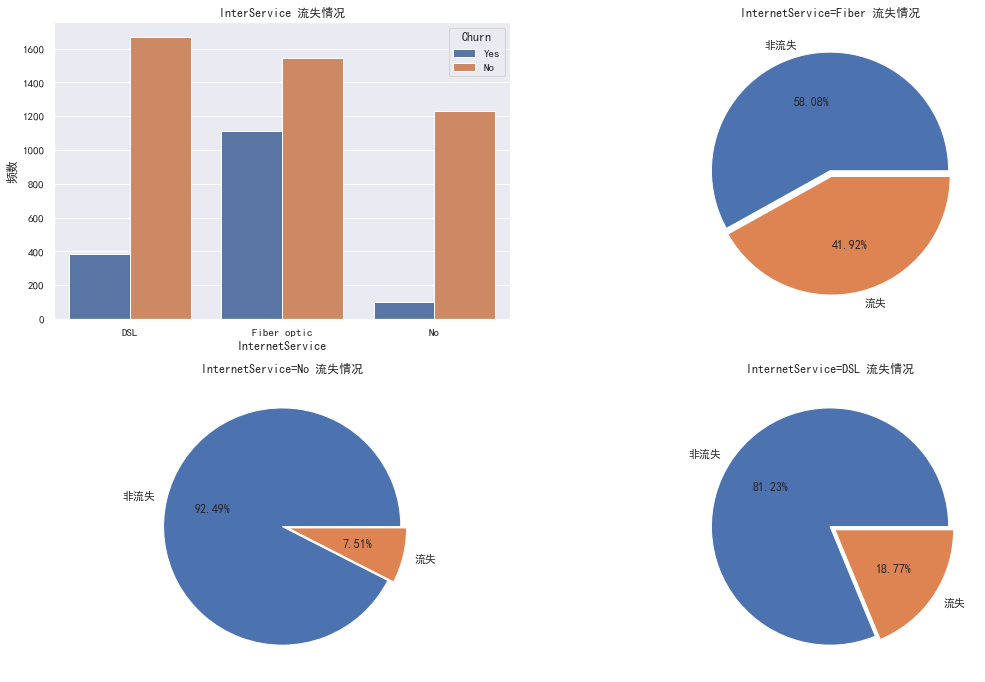

In [28]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)

ax = sns.countplot(x='InternetService', data=data, hue='Churn', hue_order=['Yes', 'No'])
ax.set(xlabel='InternetService', ylabel='频数', title='InterService 流失情况')

churn_1 = data[data['InternetService']=='Fiber optic']['Churn'].value_counts(normalize=True).to_dict()
churn_0 = data[data['InternetService']=='No']['Churn'].value_counts(normalize=True).to_dict()
churn_2 = data[data['InternetService']=='DSL']['Churn'].value_counts(normalize=True).to_dict()


plt.subplot(2, 2, 2)
plt.pie(
    churn_1.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05], 
    autopct='%1.2f%%', 
    )
plt.title('InternetService=Fiber 流失情况') 

plt.subplot(2, 2, 3)
plt.pie(
    churn_0.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('InternetService=No 流失情况') 

plt.subplot(2, 2, 4)
plt.pie(
    churn_2.values(), 
    labels=['非流失', '流失'],  
    explode=[0, 0.05],  
    autopct='%1.2f%%',  
    )
plt.title('InternetService=DSL 流失情况') 

光纤客户流失率相比较于dsl和无网络服务客户较高

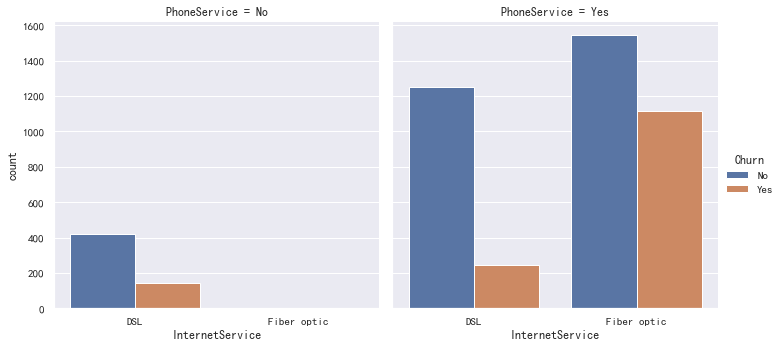

In [29]:
phone_internet = data[(data['InternetService']!='No')]
ax = sns.catplot(data=phone_internet, col='PhoneService', x='InternetService', hue='Churn', kind='count')

选择互联网服务流失率更高，同时Fiber比DSL流失率高

#### 2.5 互联网增值服务

**六项增值服务**
- OnlineSecurity(在线安全)
- OnlineBackup(在下备份）
- DeviceProtection(设备保护)
- TechSupport(技术支持)
- StreamingTV(流媒体电视)
- StreamingMovies(流媒体电影)

[Text(0.5, 0, '增值服务'), Text(0, 0.5, '流失用户数')]

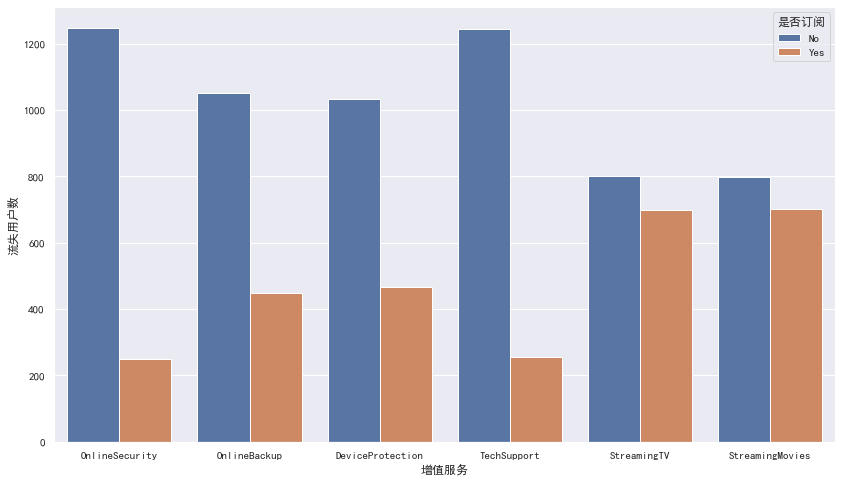

In [30]:
fig = plt.figure(figsize=(14, 8))

extra_service = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data1 = data[(data['InternetService'] !='No') & (data['Churn']=='Yes')]
data1 = pd.melt(data1[extra_service]).rename({'value': '是否订阅'}, axis=1)

ax = sns.countplot(x='variable', data=data1, hue='是否订阅', hue_order=['No', 'Yes'])
ax.set(xlabel='增值服务', ylabel='流失用户数')

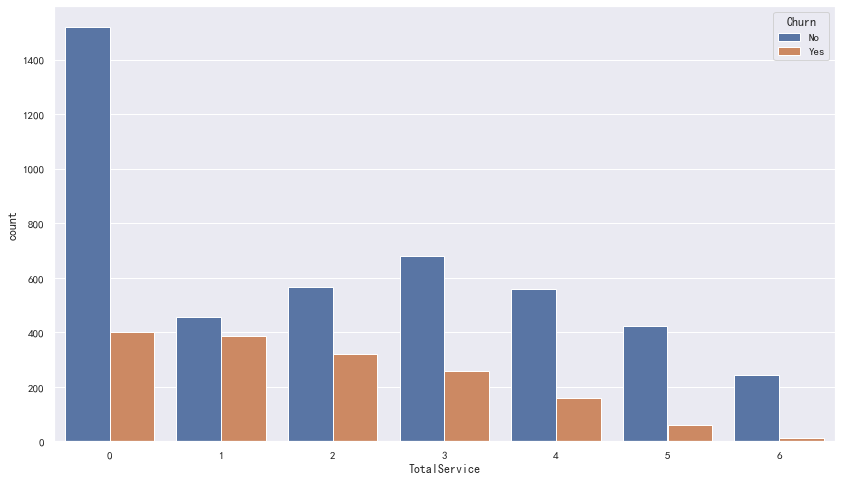

In [35]:
fig = plt.figure(figsize=(14, 8))
data1 = data.copy()
data1['TotalService'] = (data1[extra_service]== 'Yes').sum(axis=1)
ax = sns.countplot(data=data1, x='TotalService', hue='Churn')

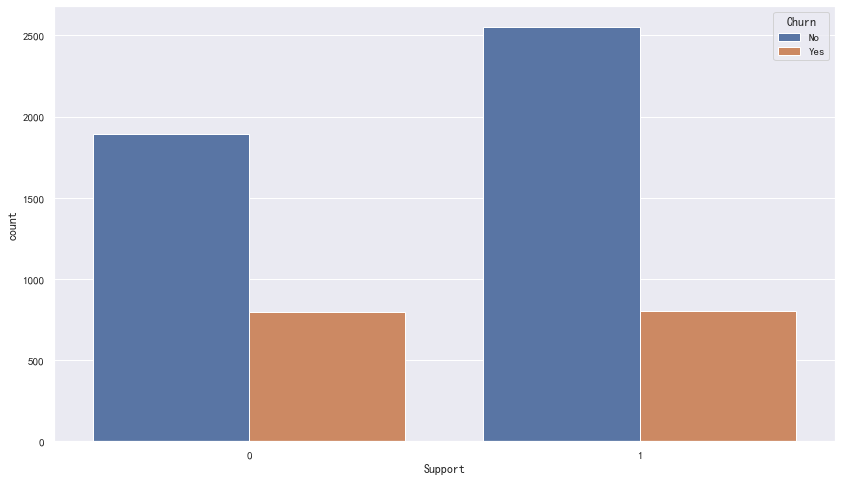

In [36]:
fig = plt.figure(figsize=(14, 8))
data1 = data.copy()
data1['Support'] = np.where((data1['OnlineBackup'] == 'Yes') | (data1['DeviceProtection'] == 'Yes') | (data1['TechSupport'] == 'Yes'), 1,0)
    
ax = sns.countplot(data=data1, x='Support', hue='Churn')

在六项增值服务中，OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport四项服务流失情况有明显区别

## 3、特征工程
- 特征衍生
- 字符编码
- One-Hot 编码
- 标准化
- 特征选择

In [19]:
file_name = os.path.join(data_path,'train.csv')
data = pd.read_csv(file_name)

In [20]:
# 定义transformer
def bin_preprocessing(data):
    
    df = data.copy()
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # 补足缺失值, 并将刚开户客户消费月数改为1
    df['TotalCharges'] = np.where(df['TotalCharges'].isnull(), df['MonthlyCharges'], df['TotalCharges'])
    df.loc[df['MonthlyCharges']==0, 'MonthlyCharges'] = 1
    
    df['Total_Services'] = (df[['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']] == 'Yes').sum(axis=1)
    
    df['InternetService']= np.where(df.InternetService != 'No', 'Yes', 'No')  # 是否有因特网服务
    df['Contract'] = np.where(df['Contract'] != 'Month-to-month', 'Yes', 'No') # 月付
    df['MonthPayMethod'] = np.where((df['PaymentMethod'] == 'Electronic check') & (df['Contract']=='Yes'), 'Yes', 'No')
    df['isFib'] = np.where((df['InternetService'] != 'Fiber optic'), 'Yes', 'No')
    df['StreamingTV'] = np.where((df['StreamingTV'] == 'Yes'), 'Yes', 'No') # 是否有流媒体电视
    df['StreamingMovies'] = np.where((df['StreamingMovies'] == 'Yes'), 'Yes', 'No') # 是否有流媒体电视

    df['support'] = np.where((df['OnlineBackup'] == 'Yes') | (df['DeviceProtection'] == 'Yes') | (df['TechSupport'] == 'Yes'), 'Yes', 'No')
    # tenure
    df['tenure1'] = np.where(df['tenure']<= 6, 'Yes', 'No')
    df['MothlyCharges1'] = np.where(df['MonthlyCharges'].between(70, 110), 'Yes', 'No')
    
    return df

def oht_preprocessing(data):
    
    df = data.copy()
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # 补足缺失值, 并将刚开户客户消费月数改为1
    df['TotalCharges'] = np.where(df['TotalCharges'].isnull(), df['MonthlyCharges'], df['TotalCharges'])
    df.loc[df['MonthlyCharges']==0, 'MonthlyCharges'] = 1
    
    df['Total_Services'] = (df[['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']] == 'Yes').sum(axis=1)
    df['support'] = np.where((df['OnlineBackup'] == 'Yes') | (df['DeviceProtection'] == 'Yes') | (df['TechSupport'] == 'Yes'), 'Yes', 'No')
    
    return df

def bar_plot(data, feature, title):
    yes = data[data['Churn']=='Yes'][feature].value_counts().to_dict()
    no = data[data['Churn']=='No'][feature].value_counts().to_dict()

    bar = Bar()
    bar.add_xaxis(list(yes.keys()))
    bar.add_yaxis("Churn=Yes", list(yes.values()))
    bar.add_yaxis("Churn=No", list(no.values()))
    bar.set_global_opts(title_opts=opts.TitleOpts(title=title))
    return bar

def plot_confusion_matrix(clf, x, y, classes, x_test=None, y_test=None, title='Confustion Matrix', cmap=plt.cm.Blues):
    
    pred = clf.predict(x)
    cm = confusion_matrix(y, pred)
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicated label')
    if y_test is not None:
        pred_test = clf.predict(x_test)
        cm_test = confusion_matrix(y_test, pred_test)
        plt.subplot(1, 2, 2)
        plt.imshow(cm_test, interpolation='nearest', cmap=cmap)
        plt.title('Confustion Matrix —— Test')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)

        thresh = cm_test.max() / 2
        for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
            plt.text(j, i, cm_test[i, j], horizontalalignment='center', color='white' if cm_test[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicated label')
    
def plot_roc_curve(clf, x, y, x_test, y_test=None, model=None):
    """
    ROC AUC
    @params:
    
    """
    plt.figure(figsize=(14, 6))
    pred_proba = clf.predict_proba(x)[:,1]
    fpr,tpr,thresholds = roc_curve(y, pred_proba)
    plt.subplot(1, 2, 1)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="blue")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
    if y_test is not None:
        pred_proba_test = clf.predict_proba(x_test)[:,1]
        fpr,tpr,thresholds = roc_curve(y_test, pred_proba_test)
        plt.subplot(1, 2, 2)
        plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
        plt.plot([1,0],[1,0],linestyle = "dashed",color ="blue")
        plt.legend(loc = "best")
        plt.title("ROC - CURVE & AREA UNDER CURVE —— Test",fontsize=20)


def print_result(clf, x, y=None, data='训练集'):
    print ("*****************************************************************************************")
    print ("MODEL - OUTPUT: {name}".format(name=data))
    print ("*****************************************************************************************")
    pred = clf.predict(x)
    
    print ("\naccuracy_score :",accuracy_score(y, pred))
    
    print ("\nclassification report :\n",(classification_report(y, pred)))
    
def plot_feature_importance(clf, x, of_type='feat'):
    
    plt.figure(figsize=(12, 6))
    
    if  of_type == "feat":
        dataframe = pd.DataFrame(clf.feature_importances_, x.columns).reset_index()
    else:
        dataframe = pd.DataFrame(clf.coef_.ravel(), x.columns).reset_index()
        
    dataframe = dataframe.rename(columns={"index":"features",0:"coefficients"})
    dataframe = dataframe.sort_values(by="coefficients",ascending = False)
    ax = sns.barplot(x = "coefficients" ,y ="features",data=dataframe,palette="husl")
    plt.title("FEATURE IMPORTANCES",fontsize =20)
    for i,j in enumerate(dataframe["coefficients"]):
        ax.text(.011,i,j,weight = "bold")
    plt.show()

In [21]:
# 数据类型
id_name = 'customerID'
target_name = 'Churn'

**数据二值化**

In [22]:
data_bin = bin_preprocessing(data)
categorical_features_bin   = data_bin.nunique()[data_bin.nunique() < 5].keys().tolist()

numeric_features_bin   = [x for x in data_bin.columns if x not in categorical_features_bin + [id_name]]
categorical_features_bin.remove(target_name)
data_bin.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Total_Services,MonthPayMethod,isFib,support,tenure1,MothlyCharges1
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Yes,No,...,Electronic check,29.85,29.85,No,1,No,Yes,Yes,Yes,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,Yes,Yes,...,Mailed check,56.95,1889.50,No,3,No,Yes,Yes,No,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,Yes,Yes,...,Mailed check,53.85,108.15,Yes,3,No,Yes,Yes,Yes,No
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,Yes,Yes,...,Bank transfer (automatic),42.30,1840.75,No,3,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Yes,No,...,Electronic check,70.70,151.65,Yes,1,No,Yes,No,Yes,Yes


In [23]:
print("字符型变量：\n", len(categorical_features_bin), categorical_features_bin)
print("数值型变量：\n", len(numeric_features_bin), numeric_features_bin)

字符型变量：
 21 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthPayMethod', 'isFib', 'support', 'tenure1', 'MothlyCharges1']
数值型变量：
 4 ['tenure', 'MonthlyCharges', 'TotalCharges', 'Total_Services']


**数据OneHotencoder**

In [24]:
data_oht = oht_preprocessing(data)
categorical_features_oht   = data_oht.nunique()[data_oht.nunique() < 5].keys().tolist()

numeric_features_oht   = [x for x in data_oht.columns if x not in categorical_features_oht + [id_name]]
categorical_features_oht.remove(target_name)

In [25]:
print("字符型变量：\n", len(categorical_features_oht), categorical_features_oht)
print("数值型变量：\n", len(numeric_features_oht), numeric_features_oht)

字符型变量：
 17 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'support']
数值型变量：
 4 ['tenure', 'MonthlyCharges', 'TotalCharges', 'Total_Services']


## 4、模型

#### 模型一：Bin

In [26]:
X = data_bin.drop(['customerID', 'Churn'], axis=1)
y = data_bin['Churn'].map({'Yes':1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# 数据管道
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown="ignore"))])
    
def estimator_clf(clf, X, y):
    
    global model_f1, model_auc, model_recall, model_roc_auc, accuracy
    
    pred = clf.predict(X)
    pred_proba = clf.predict_proba(X)[:, 1]
    accuracy = accuracy_score(y, pred)
    model_f1 = f1_score(y, pred)
    model_roc_auc = roc_auc_score(y, pred_proba)
    fpr, tpr, thresholds = roc_curve(y, pred_proba)
    model_auc = auc(fpr, tpr)
    model_recall = recall_score(y, pred)

In [28]:
def train_transform(data1):
    data = data1.copy()
    num_encoder =  StandardScaler()
    cat_encoder = OneHotEncoder(handle_unknown="ignore")
    data[numeric_features_bin] = num_encoder.fit_transform(data[numeric_features_bin])
    oht_transform = pd.DataFrame(cat_encoder.fit_transform(data[categorical_features_bin]).toarray(), 
                                 columns=cat_encoder.get_feature_names(categorical_features_bin),
                                index=data.index)
    data = pd.concat([data, oht_transform], axis=1)
    data.drop(categorical_features_bin, axis=1, inplace=True)
    return data, cat_encoder, num_encoder

def test_transform(data1, cat_encoder, num_encoder):
    data = data1.copy()
    data[numeric_features_bin] = num_encoder.transform(data[numeric_features_bin])
    oht_transform = pd.DataFrame(cat_encoder.transform(data[categorical_features_bin]).toarray(), 
                                 columns=cat_encoder.get_feature_names(categorical_features_bin),
                                index=data.index)
    data = pd.concat([data, oht_transform], axis=1)
    data.drop(categorical_features_bin, axis=1, inplace=True)
    return data

In [29]:
X_train1, cat_encoder, num_encoder = train_transform(X_train)
X_test1 = test_transform(X_test, cat_encoder, num_encoder)

In [31]:
'''
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [0.01, 0.05, 0.1, 0.5, 1],
    #'classifier__solver' : ['liblinear', 'lbfgs'],
    'classifier__class_weight':['balanced']
'''
param_grid = {
    'classifier__penalty' : ['l2'],
    'classifier__C' : [0.05],
    #'classifier__solver' : ['liblinear', 'lbfgs'],
    'classifier__class_weight':['balanced']
}

lr =LogisticRegression()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', categorical_transformer, categorical_features_bin)
    ]
)
pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', lr)
            ])
cv_lr = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, cv=10, verbose=1)
cv_lr.fit(X_train, y_train)
print("最佳参数：", cv_lr.best_params_)
print("最佳得分：", cv_lr.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


最佳参数： {'classifier__C': 0.05, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
最佳得分： 0.7554809814691238


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7592056268100952

classification report :
               precision    recall  f1-score   support

           0       0.91      0.75      0.82      3550
           1       0.53      0.79      0.63      1284

    accuracy                           0.76      4834
   macro avg       0.72      0.77      0.73      4834
weighted avg       0.81      0.76      0.77      4834

*****************************************************************************************
MODEL - OUTPUT: 测试集
*****************************************************************************************

accuracy_score : 0.7551695616211745

classification report :
               precision    recall  f1-score   support

           0       0.91      0.74      0.82       894
           1       0.52      0.80     

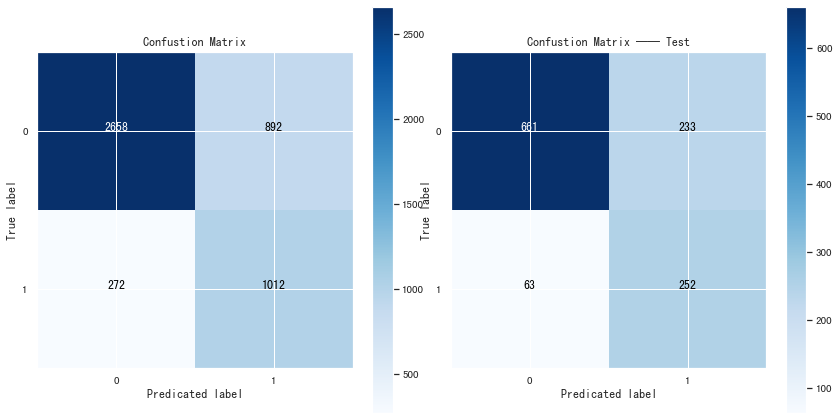

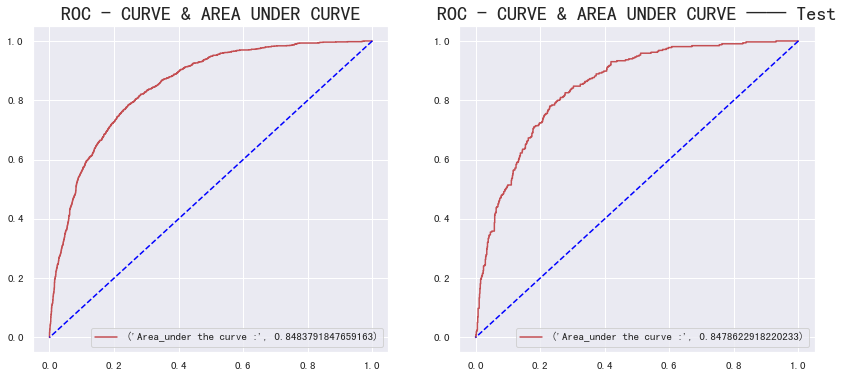

In [32]:
print_result(cv_lr, X_train, y_train)
print_result(cv_lr, X_test, y_test, data='测试集')
plot_confusion_matrix(cv_lr, X_train, y_train, classes=[0, 1], x_test=X_test, y_test=y_test)

plot_roc_curve(cv_lr, X_train, y_train, X_test, y_test)

In [260]:

lr = LogisticRegression(**{'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2'})
lr.fit(X_im, y_im)
# dataframe = pd.DataFrame(lr.coef_.ravel(), X_train1.columns).reset_index()
        
# dataframe = dataframe.rename(columns={"index":"features",0:"coefficients"})
# dataframe = dataframe.sort_values(by="coefficients",ascending = False)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [51]:
# print_result(lr, X_train1, y_train)
# print_result(lr, X_test1, y_test, '测试集')
# plot_confusion_matrix(lr, X_train1, y_train, classes=[0, 1], x_test=X_test1, y_test=y_test)

# plot_roc_curve(lr, X_train1, y_train, x_test=X_test1, y_test=y_test)

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7798591549295775

classification report :
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      3550
           1       0.77      0.80      0.78      3550

    accuracy                           0.78      7100
   macro avg       0.78      0.78      0.78      7100
weighted avg       0.78      0.78      0.78      7100

*****************************************************************************************
MODEL - OUTPUT: 测试集
*****************************************************************************************

accuracy_score : 0.7626137303556658

classification report :
               precision    recall  f1-score   support

           0       0.92      0.75      0.82       894
           1       0.53      0.80     

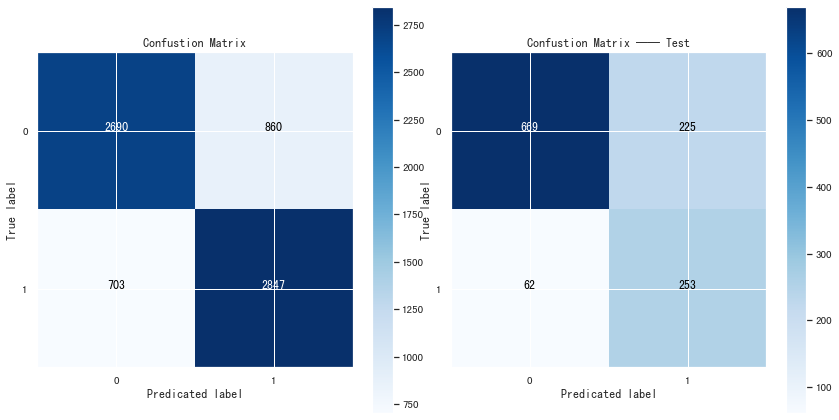

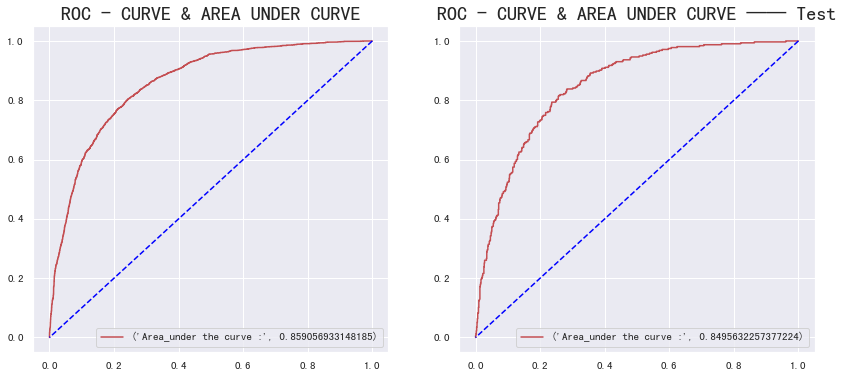

In [261]:
print_result(grid_sear, X_im, y_im)
print_result(grid_sear, X_test1, y_test, '测试集')
plot_confusion_matrix(grid_sear, X_im, y_im, classes=[0, 1], x_test=X_test1, y_test=y_test)

plot_roc_curve(grid_sear, X_im, y_im, x_test=X_test1, y_test=y_test)

#### RandomForest

In [52]:
'''
    'classifier__n_estimators' : list(range(100,500,50)),
    'classifier__max_features' : list(range(6,32,5)),
    'classifier__max_depth': [ 6, 7, 8, 9],
    'classifier__class_weight': ['balanced']
'''
params_grid={
    'classifier__n_estimators' : [150],
    'classifier__max_features' :[11],
    'classifier__max_depth': [ 6],
    'classifier__class_weight': ['balanced']
}

rf =RandomForestClassifier()
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

cv_rf = GridSearchCV(rf_pipeline, param_grid=params_grid, n_jobs=-1, cv=10, verbose=1)
cv_rf.fit(X_train, y_train)
print("最佳参数：", cv_rf.best_params_)
print("最佳得分：", cv_rf.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


最佳参数： {'classifier__class_weight': 'balanced', 'classifier__max_depth': 6, 'classifier__max_features': 11, 'classifier__n_estimators': 150}
最佳得分： 0.7567215064250638


*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7767894083574679

classification report :
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      3550
           1       0.55      0.82      0.66      1284

    accuracy                           0.78      4834
   macro avg       0.74      0.79      0.75      4834
weighted avg       0.82      0.78      0.79      4834

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7559966914805625

classification report :
               precision    recall  f1-score   support

           0       0.92      0.74      0.82       894
           1       0.52      0.81     

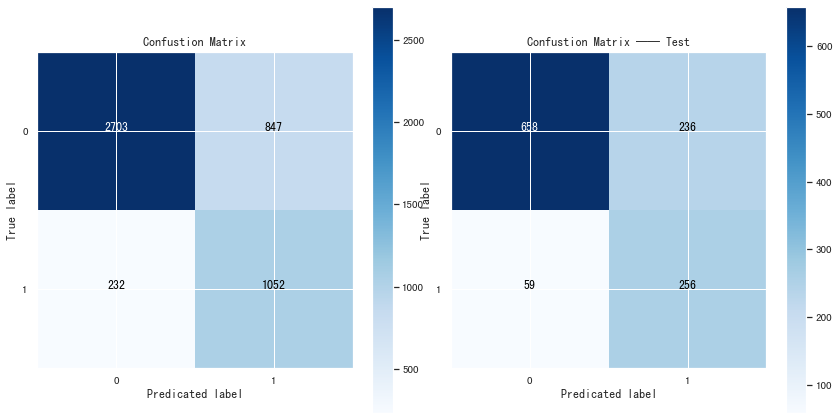

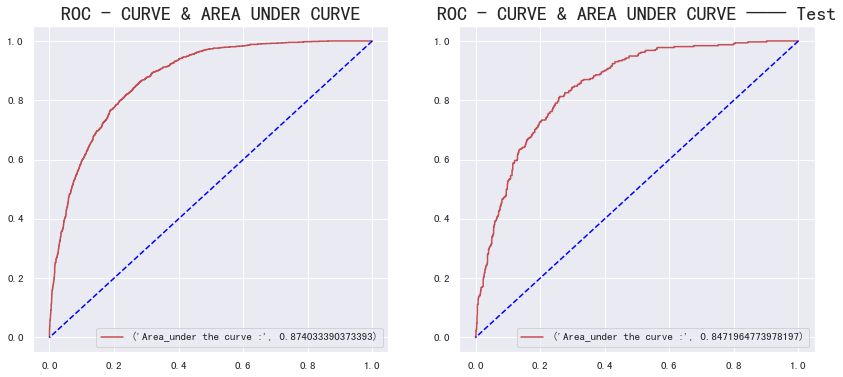

In [53]:
print_result(cv_rf, X_train, y_train)
print_result(cv_rf, X_test, y_test)
plot_confusion_matrix(cv_rf, X_train, y_train, classes=[0, 1], x_test=X_test, y_test=y_test)
plot_roc_curve(cv_rf, X_train, y_train, X_test, y_test)

In [54]:
# 再次训练
rf_params = {
    'class_weight': 'balanced', 
    'max_depth': 6, 
    'max_features': 11, 
    'n_estimators': 150
}
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train1, y_train)
rf_feature = pd.DataFrame(rf.feature_importances_, X_train1.columns).reset_index().rename(columns={"index":"features",0:"coefficients"})
rf_feature = rf_feature.sort_values(by="coefficients",ascending = False)

In [55]:
# print_result(rf, X_train1, y_train)
# print_result(rf, X_test1, y_test, '测试集')
# plot_confusion_matrix(rf, X_train1, y_train, classes=[0, 1], x_test=X_test1, y_test=y_test)
# plot_roc_curve(rf, X_train1, y_train, x_test=X_test1, y_test=y_test)

#### XGBOOST

In [60]:
'''
"
    "classifier__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "classifier__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    'classifier__n_estimators' : list(range(100,500,50)),
    'classifier__max_depth':range(3,10,2),
    'classifier__min_child_weight':range(1,6,2),
    'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
'''
params_grid ={ 
    "classifier__learning_rate": [0.1],
    'classifier__n_estimators' : [150],
    'classifier__max_depth': [4],
    'classifier__min_child_weight':[5],
    'classifier__gamma':[0],
    'classifier__subsample':[0.6],
    'classifier__colsample_bytree':[0.6],
    "classifier__scale_pos_weight":[4]
}

xgb = XGBClassifier()
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

cv_xgb = GridSearchCV(xgb_pipeline, param_grid=params_grid, n_jobs=-1, cv=10, verbose=1)
cv_xgb.fit(X_train, y_train)
print("最佳参数：", cv_xgb.best_params_)
print("最佳得分：", cv_xgb.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished


最佳参数： {'classifier__colsample_bytree': 0.6, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 150, 'classifier__scale_pos_weight': 4, 'classifier__subsample': 0.6}
最佳得分： 0.725893605735503


*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7784443525031031

classification report :
               precision    recall  f1-score   support

           0       0.96      0.73      0.83      3550
           1       0.55      0.91      0.69      1284

    accuracy                           0.78      4834
   macro avg       0.75      0.82      0.76      4834
weighted avg       0.85      0.78      0.79      4834

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7311827956989247

classification report :
               precision    recall  f1-score   support

           0       0.93      0.69      0.79       894
           1       0.49      0.84     

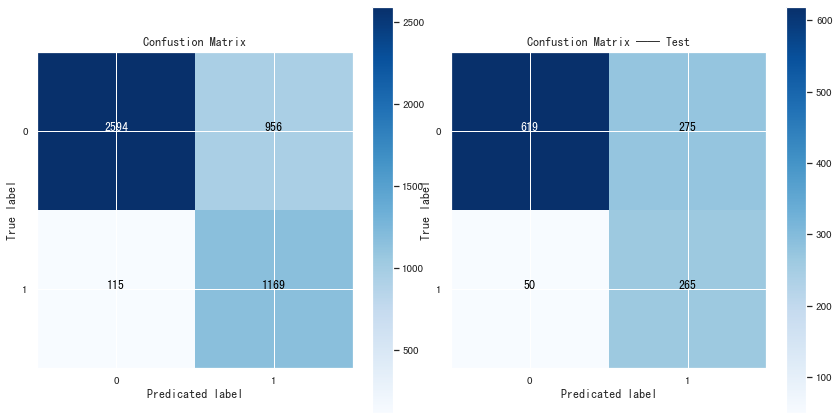

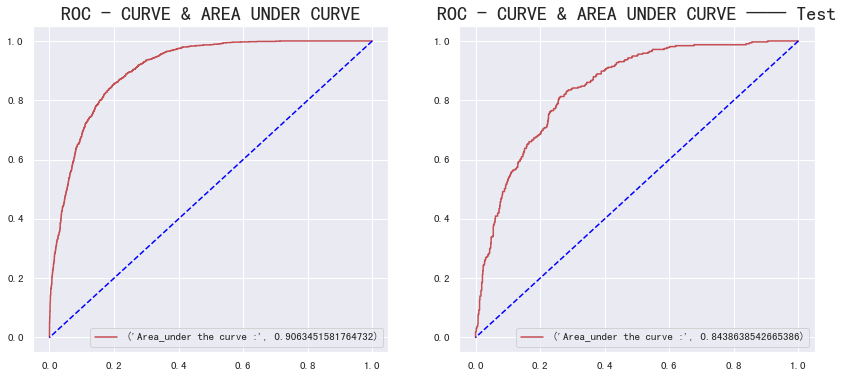

In [61]:
print_result(cv_xgb, X_train, y_train)
print_result(cv_xgb, X_test, y_test)
plot_confusion_matrix(cv_xgb, X_train, y_train, classes=[0, 1], x_test=X_test, y_test=y_test)
plot_roc_curve(cv_xgb, X_train, y_train, X_test, y_test)

In [72]:
# 再次训练
xgb_params =  {
    'colsample_bytree': 0.6, 
    'gamma': 0, 
    'learning_rate': 0.1, 
    'max_depth': 3, 
    'min_child_weight': 5, 
    'n_estimators': 150, 
    'scale_pos_weight': 3, 
    'subsample': 0.6}
xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train1, y_train)
xgb_feature = pd.DataFrame(xgb.feature_importances_, X_train1.columns).reset_index().rename(columns={"index":"features",0:"coefficients"})
xgb_feature = xgb_feature.sort_values(by="coefficients",ascending = False)

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7631361191559785

classification report :
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      3550
           1       0.53      0.84      0.65      1284

    accuracy                           0.76      4834
   macro avg       0.73      0.79      0.74      4834
weighted avg       0.82      0.76      0.78      4834

*****************************************************************************************
MODEL - OUTPUT: 测试集
*****************************************************************************************

accuracy_score : 0.7568238213399504

classification report :
               precision    recall  f1-score   support

           0       0.92      0.74      0.82       894
           1       0.52      0.81     

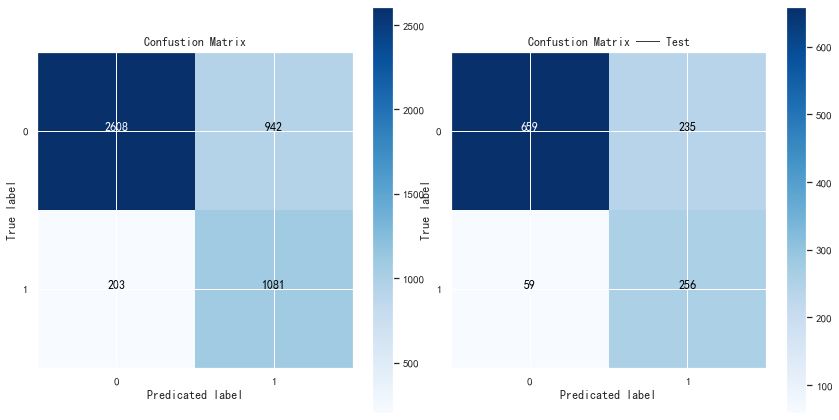

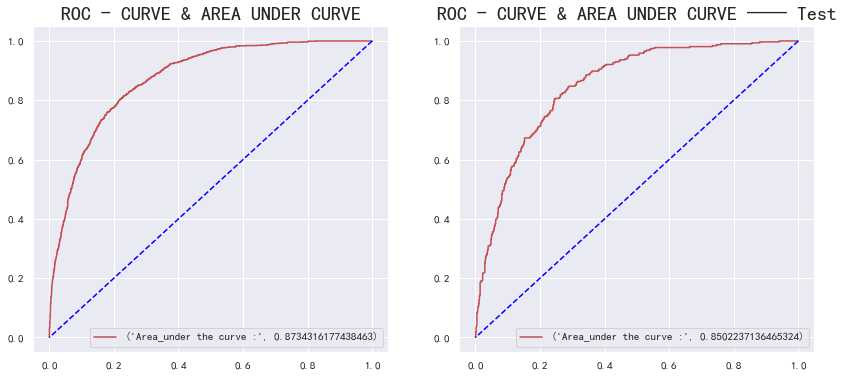

In [254]:
# print_result(xgb, X_train1, y_train)
# print_result(xgb, X_test1, y_test, '测试集')
# plot_confusion_matrix(xgb, X_train1, y_train, classes=[0, 1], x_test=X_test1, y_test=y_test)
# plot_roc_curve(xgb, X_train1, y_train, x_test=X_test1, y_test=y_test)

#### lightgbm

In [ ]:
# lightgbm grid_search
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_val,y_val)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 200

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=42, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(X_train, y_train, **fit_params)
print('Best params: {} '.format(grid_search.best_params_))

opt_parameters =  grid_search.best_params_

#### GaussianNB

In [62]:
gnb = GaussianNB()
gnb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gnb)
])
gnb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetServ

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7105045492142267

classification report :
               precision    recall  f1-score   support

           0       0.92      0.67      0.77       894
           1       0.47      0.83      0.60       315

    accuracy                           0.71      1209
   macro avg       0.69      0.75      0.69      1209
weighted avg       0.80      0.71      0.73      1209

*****************************************************************************************
MODEL - OUTPUT: 测试集
*****************************************************************************************

accuracy_score : 0.7105045492142267

classification report :
               precision    recall  f1-score   support

           0       0.92      0.67      0.77       894
           1       0.47      0.83     

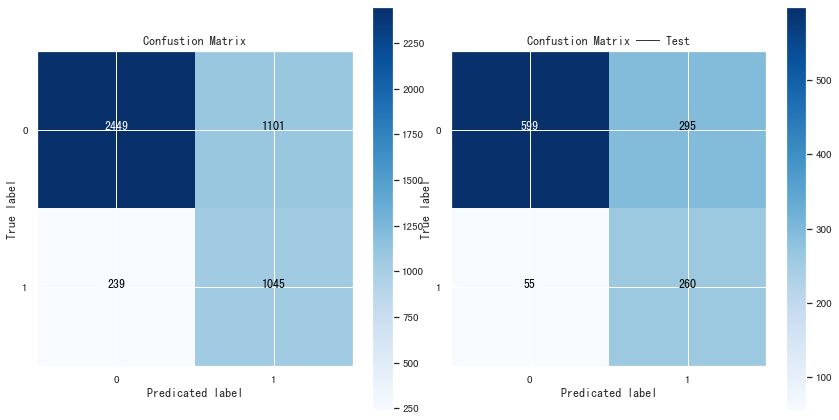

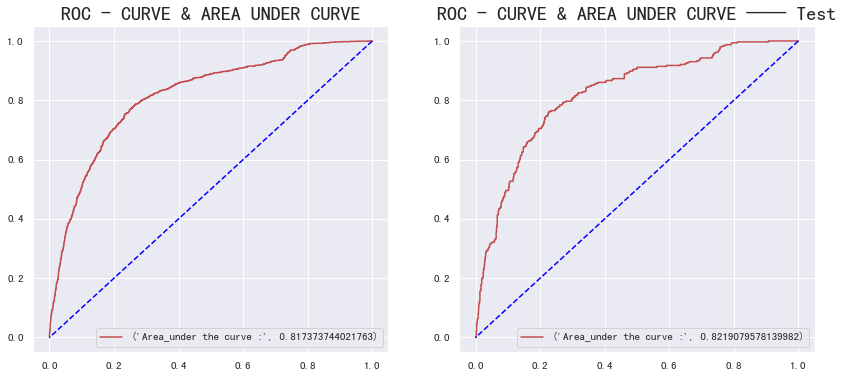

In [63]:
print_result(gnb_pipeline, X_test, y_test)
print_result(gnb_pipeline, X_test, y_test, '测试集')
plot_confusion_matrix(gnb_pipeline, X_train, y_train, classes=[0, 1], x_test=X_test, y_test=y_test)
plot_roc_curve(gnb_pipeline,  X_train, y_train, X_test, y_test)

In [73]:
gnb = GaussianNB()
gnb.fit(X_train1, y_train)

GaussianNB()

#### SVM


In [266]:
'''
    "classifier__gamma": [0.001, 0.01, 0.02],
    "classifier__kernel": ['rbf'],
'''
params_grid= {
    "classifier__C": [50],
    "classifier__kernel": ['rbf'],
    'classifier__class_weight': ['balanced'],
    "classifier__gamma": [0.5]
}

svc = SVC()
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svc)
])

cv_svc = GridSearchCV(svc_pipeline, params_grid, n_jobs=-1, cv=10, verbose=1)
cv_svc.fit(X_train, y_train)
print("最佳参数：", cv_svc.best_params_)
print("最佳得分：", cv_svc.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.1s finished


最佳参数： {'classifier__C': 50, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.5, 'classifier__kernel': 'rbf'}
最佳得分： 0.7490614787057475


*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.9557302441042614

classification report :
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      3550
           1       0.86      0.99      0.92      1284

    accuracy                           0.96      4834
   macro avg       0.93      0.97      0.95      4834
weighted avg       0.96      0.96      0.96      4834

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7485525227460711

classification report :
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       894
           1       0.52      0.47     

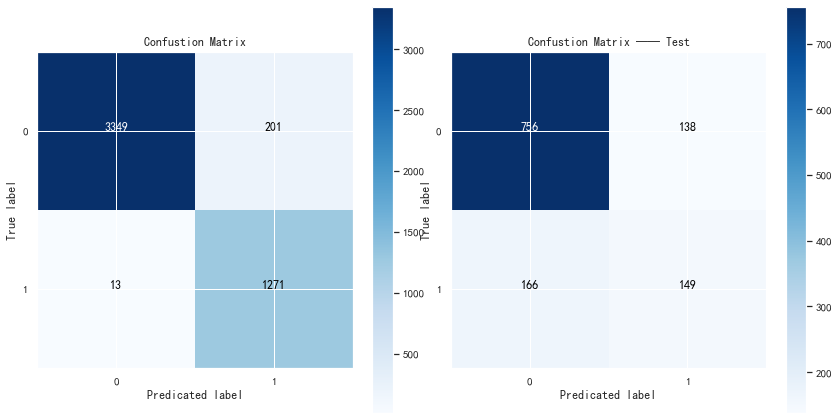

In [267]:
print_result(cv_svc, X_train, y_train)
print_result(cv_svc, X_test, y_test)
plot_confusion_matrix(cv_svc, X_train, y_train, classes=[0, 1], x_test=X_test, y_test=y_test)
#plot_roc_curve(cv_svc, X_train, y_train, X_test, y_test)

#### Stacking

In [79]:
from sklearn.model_selection import cross_val_score
classifiers = [rf, xgb, gnb]
sclf = StackingClassifier(classifiers=classifiers, meta_classifier=lr,use_probas=True)
for clf, label in zip([rf, xgb, gnb, sclf],
                      ['Random Forest', 'XGBoost', 'Gaussin', 'StackingClassifier']):
    scores = cross_val_score(clf, X_train1, y_train, cv=3, scoring='roc_auc')

    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))



Accuracy: 0.84 (+/- 0.00) [Random Forest]
Accuracy: 0.84 (+/- 0.00) [XGBoost]
Accuracy: 0.82 (+/- 0.01) [Gaussin]
Accuracy: 0.84 (+/- 0.00) [StackingClassifier]


In [80]:
sclf.fit(X_train1, y_train)
#X_train1.sample()

StackingClassifier(classifiers=[RandomForestClassifier(class_weight='balanced',
                                                       max_depth=6,
                                                       max_features=11,
                                                       n_estimators=150),
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.6, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=5, missing=nan,
                                        

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7904426975589574

classification report :
               precision    recall  f1-score   support

           0       0.93      0.78      0.84      3550
           1       0.57      0.83      0.68      1284

    accuracy                           0.79      4834
   macro avg       0.75      0.80      0.76      4834
weighted avg       0.83      0.79      0.80      4834

*****************************************************************************************
MODEL - OUTPUT: 训练集
*****************************************************************************************

accuracy_score : 0.7626137303556658

classification report :
               precision    recall  f1-score   support

           0       0.91      0.76      0.82       894
           1       0.53      0.78     

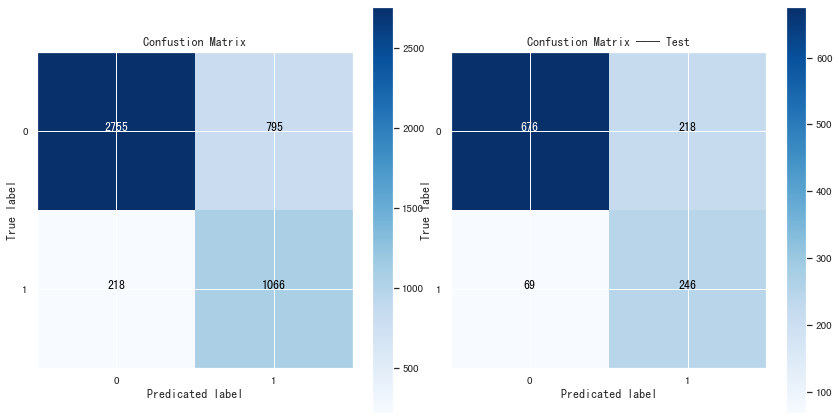

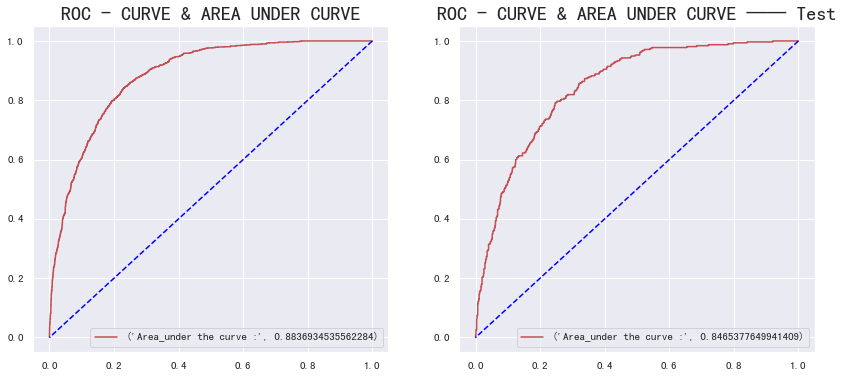

In [81]:
print_result(sclf, X_train1, y_train)
print_result(sclf, X_test1, y_test)
plot_confusion_matrix(sclf, X_train1, y_train, classes=[0, 1], x_test=X_test1, y_test=y_test)
plot_roc_curve(sclf, X_train1, y_train, X_test1, y_test)

### 4.2 模型评测

### 训练集

In [226]:
model_list_train = []
f1_list_train = []
auc_list_train = []
roc_auc_list_train = []
recall_list_train = []
accuracy_list_train = []
classifier = [
    ('LR', lr),
    ('XGBoost', xgb), 
    ('RandomForest', rf), 
    ('GaussianNB', gnb),
    ('Stacking', sclf)]
for name, clf in classifier:
    estimator_clf(clf, X_train1, y_train)
    model_list_train.append(name)
    f1_list_train.append(model_f1)
    auc_list_train.append(model_auc)
    roc_auc_list_train.append(model_roc_auc)
    recall_list_train.append(model_recall)
    accuracy_list_train.append(accuracy)

In [227]:
estimator_train = pd.DataFrame({'Model': model_list_train, 'Accuracy_train': accuracy_list_train, 'Recall_train': recall_list_train, 'AUC_train': auc_list_train, 'F1_Score_train': f1_list_train})

### 测试集评估

In [228]:
model_list_test = []
f1_list_test = []
auc_list_test = []
roc_auc_list_test = []
recall_list_test = []
accuracy_list_test = []
classifier_test = [
    ('LR', lr),
    ('XGBoost', xgb), 
    ('RandomForest', rf), 
    ('GaussianNB', gnb),
    ('Stacking', sclf)]
for name, clf in classifier:
    estimator_clf(clf, X_test1, y_test)
    model_list_test.append(name)
    f1_list_test.append(model_f1)
    auc_list_test.append(model_auc)
    roc_auc_list_test.append(model_roc_auc)
    recall_list_test.append(model_recall)
    accuracy_list_test.append(accuracy)

In [229]:
estimator_test = pd.DataFrame({'Model': model_list_test, 'Accuracy': accuracy_list_test, 'Recall': recall_list_test, 'AUC': auc_list_test, 'F1_Score': f1_list_test})

### 验证集评估

In [230]:
valid_data = pd.read_csv(data_path + '/valid.csv')
valid_data = bin_preprocessing(valid_data)
valid_data_bin = test_transform(valid_data, cat_encoder, num_encoder)
X_valid = valid_data_bin.drop(['customerID', 'Churn'], axis=1)
y_valid = valid_data_bin['Churn'].map({'Yes':1, 'No': 0})

In [231]:
model_list = []
f1_list = []
auc_list = []
roc_auc_list = []
recall_list = []
accuracy_list = []
classifier = [
    ('LR', lr),
    ('XGBoost', xgb), 
    ('RandomForest', rf), 
    ('GaussianNB', gnb),
    ('Stacking', sclf)]
for name, clf in classifier:
    estimator_clf(clf, X_valid, y_valid)
    model_list.append(name)
    f1_list.append(model_f1)
    auc_list.append(model_auc)
    roc_auc_list.append(model_roc_auc)
    recall_list.append(model_recall)
    accuracy_list.append(accuracy)

In [232]:
estimator_valid = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list, 'Recall': recall_list, 'AUC': auc_list, 'F1_Score': f1_list})

In [237]:
# 验证集和测试集合并
X_merge = X_valid.append(X_test1)
y_merge = y_valid.append(y_test)

model_list_merge = []
f1_list_merge = []
auc_list_merge = []
roc_auc_list_merge = []
recall_list_merge = []
accuracy_list_merge = []
classifier = [
    ('LR', lr),
    ('XGBoost', xgb), 
    ('RandomForest', rf), 
    ('GaussianNB', gnb),
    ('Stacking', sclf)]
for name, clf in classifier:
    estimator_clf(clf, X_merge, y_merge)
    model_list_merge.append(name)
    f1_list_merge.append(model_f1)
    auc_list_merge.append(model_auc)
    roc_auc_list_merge.append(model_roc_auc)
    recall_list_merge.append(model_recall)
    accuracy_list_merge.append(accuracy)

In [238]:
estimator_merge = pd.DataFrame({'Model': model_list_merge, 'Accuracy_Merge': accuracy_list_merge, 'Recall_Merge': recall_list_merge, 'AUC_Merge': auc_list_merge, 'F1_Score_Merge': f1_list_merge})

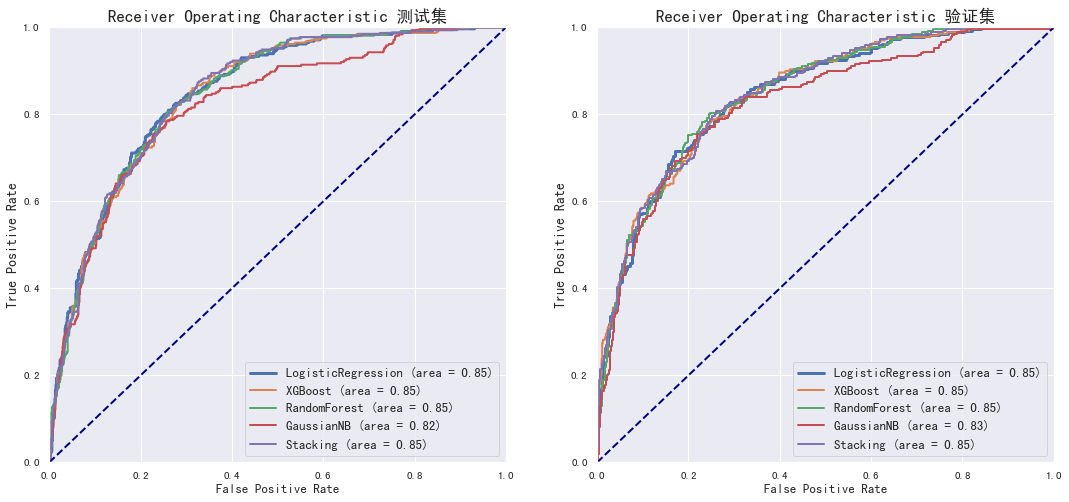

In [233]:
# plot roc-auc
# plot the ROC curves
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
y_pred = lr.predict_proba(X_test1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 
        lw=3, label='LogisticRegression (area = %0.2f)' % auc_list_test[0])

y_pred = xgb.predict_proba(X_test1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='XGBoost (area = %0.2f)' % auc_list_test[1])

y_pred = rf.predict_proba(X_test1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='RandomForest (area = %0.2f)' % auc_list_test[2])

y_pred = gnb.predict_proba(X_test1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='GaussianNB (area = %0.2f)' % auc_list_test[3])

y_pred = sclf.predict_proba(X_test1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='Stacking (area = %0.2f)' % auc_list_test[4])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic 测试集', fontsize=17)
plt.legend(loc='lower right', fontsize=13)

plt.subplot(1, 2, 2)
y_pred = lr.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot(fpr, tpr, 
        lw=3, label='LogisticRegression (area = %0.2f)' % auc_list[0])

y_pred = xgb.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='XGBoost (area = %0.2f)' % auc_list[1])

y_pred = rf.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='RandomForest (area = %0.2f)' % auc_list[2])

y_pred = gnb.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='GaussianNB (area = %0.2f)' % auc_list[3])

y_pred = sclf.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
plt.plot(fpr, tpr, 
        lw=2, label='Stacking (area = %0.2f)' % auc_list[4])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic 验证集', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

#### 指标详细数据对比

In [241]:
estimator = pd.merge(estimator_test, estimator_valid, suffixes=['_Test', '_Valid'], on='Model')
estimator = pd.merge(estimator, estimator_merge, on='Model')
estimator = pd.merge(estimator, estimator_train, on='Model').set_index('Model')

estimator = estimator.applymap(lambda x: "{:.2%}".format(x)).sort_index(axis=1)
estimator

总体指标汇总


,AUC_Merge,AUC_Test,AUC_Valid,AUC_train,Accuracy_Merge,Accuracy_Test,Accuracy_Valid,Accuracy_train,F1_Score_Merge,F1_Score_Test,F1_Score_Valid,F1_Score_train,Recall_Merge,Recall_Test,Recall_Valid,Recall_train
Model,,,,,,,,,,,,,,,,
LR,84.70%,84.80%,84.56%,84.84%,76.10%,75.60%,76.70%,75.96%,63.38%,63.17%,63.65%,63.51%,78.12%,80.32%,75.56%,78.74%
XGBoost,84.64%,84.51%,84.74%,88.22%,75.42%,74.69%,76.30%,78.07%,63.04%,62.41%,63.82%,67.26%,79.15%,80.63%,77.41%,84.81%
RandomForest,84.69%,84.64%,84.73%,87.34%,76.14%,75.27%,77.20%,77.68%,63.63%,62.95%,64.49%,66.10%,78.80%,80.63%,76.67%,81.93%
GaussianNB,82.36%,82.14%,82.62%,81.70%,72.20%,71.30%,73.30%,72.34%,61.04%,60.07%,62.23%,60.96%,82.22%,82.86%,81.48%,81.31%
Stacking,84.84%,84.76%,84.88%,88.37%,76.28%,75.85%,76.80%,79.04%,63.10%,62.94%,63.29%,67.79%,76.58%,78.73%,74.07%,83.02%


由于测试及验证集样本数量较少，所以出现指标不稳定现象，故以已有的测试集加上验证集数据作为最终测试集，给出评价指标

### 输出

In [191]:
# import joblib

# model_pkl = {
#         'features':{
#             'numeric_features': numeric_features_bin,
#             'categorical_features': categorical_features_bin
#         },
#         'model':{
#             'LR': lr,
#             'XGBoost': xgb, 
#             'RandomForest': rf, 
#             'GaussianNB': gnb,
#             'Stacking': sclf
#         },
#         'encoder':{
#             'cat_encoder': cat_encoder,
#             'num_encoder': num_encoder
#         }
#     }
# joblib.dump(model_pkl, model_path + '/model.pkl')

In [242]:
# 模型封装序列化
class TestApi:
    
    def __init__(self, model_name='Stacking'):
        self.model = {
            'LR': lr,
            'XGBoost': xgb, 
            'RandomForest': rf, 
            'GaussianNB': gnb,
            'Stacking': sclf
        }
        self.features = {
            'numeric_features': numeric_features_bin,
            'categorical_features': categorical_features_bin
        }
        
        self.encoder = {
            'cat_encoder': cat_encoder,
            'num_encoder': num_encoder
        }
        self.model_name = model_name
        
    def predict(self, X):
        X = self.preprocess(X)
        #X = X.drop(['customerID', 'Churn'], axis=1)
        predict = self.model.get(self.model_name).predict(X)
        return predict
    
    def predict_proba(self, X):
        X = self.preprocess(X)
        #X = X.drop(['customerID', 'Churn'], axis=1)
        pred_proba = self.model.get(self.model_name).predict_proba(X)
        return pred_proba
        
    def preprocess(self, X):
        X = self.bin_preprocessing(X)
        X = self.test_transform(X)
        
        return X
        
    def test_transform(self, data1):
        data = data1.copy()
        data[numeric_features_bin] = self.encoder.get('num_encoder').fit_transform(data[self.features.get('numeric_features')])
        oht_transform = pd.DataFrame(self.encoder.get('cat_encoder').fit_transform(data[self.features.get('categorical_features')]).toarray(), 
                                     columns=self.encoder.get('cat_encoder').get_feature_names(self.features.get('categorical_features')),
                                    index=data.index)
        data = pd.concat([data, oht_transform], axis=1)
        data.drop(self.features.get('categorical_features'), axis=1, inplace=True)
        return data
    
    def bin_preprocessing(self, data):
    
        df = data.copy()
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        # 补足缺失值, 并将刚开户客户消费月数改为1
        df['TotalCharges'] = np.where(df['TotalCharges'].isnull(), df['MonthlyCharges'], df['TotalCharges'])
        df.loc[df['MonthlyCharges']==0, 'MonthlyCharges'] = 1

        df['Total_Services'] = (df[['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']] == 'Yes').sum(axis=1)

        df['InternetService']= np.where(df.InternetService != 'No', 'Yes', 'No')  # 是否有因特网服务
        df['Contract'] = np.where(df['Contract'] != 'Month-to-month', 'Yes', 'No') # 月付
        df['MonthPayMethod'] = np.where((df['PaymentMethod'] == 'Electronic check') & (df['Contract']=='Yes'), 'Yes', 'No')
        df['isFib'] = np.where((df['InternetService'] != 'Fiber optic'), 'Yes', 'No')
        df['StreamingTV'] = np.where((df['StreamingTV'] == 'Yes'), 'Yes', 'No') # 是否有流媒体电视
        df['StreamingMovies'] = np.where((df['StreamingMovies'] == 'Yes'), 'Yes', 'No') # 是否有流媒体电视

        df['support'] = np.where((df['OnlineBackup'] == 'Yes') | (df['DeviceProtection'] == 'Yes') | (df['TechSupport'] == 'Yes'), 'Yes', 'No')
        # tenure
        df['tenure1'] = np.where(df['tenure']<= 6, 'Yes', 'No')
        df['MothlyCharges1'] = np.where(df['MonthlyCharges'].between(70, 110), 'Yes', 'No')

        return df

In [243]:
joblib.dump(TestApi, model_path + '/model.pkl')

['/Users/xuyiwang/Desktop/customer_churn/model/model.pkl']

In [247]:
test_model = joblib.load(model_path + '/model.pkl')
clf = test_model()
valid = pd.read_csv(data_path + '/valid.csv').sample(800)
testapi = TestApi()
test_x = valid.drop(['customerID', 'Churn'], axis=1)
test_y = valid['Churn'].map({"Yes":1, 'No': 0})

estimator_clf(clf, test_x, test_y)
print(model_auc)
print(model_recall)
print(model_f1)

0.8457168240905265
0.7477477477477478
0.6561264822134388


## 5、结论

#### 根据以上分析，得到高流失率用户的特征:

- 用户属性：老年用户，未婚用户，无亲属用户流失率相对更高；

- 签约服务：光纤用户、订阅流媒体电视、订阅电影服务，流失率更高；

- 账户信息：在网时长短，付款方式为月付，月租消费高额，采用电子支票支付，账单方式为电子账单，客户容易流失；

#### 针对上述结论，从业务角度给出相应建议：

根据业务需要，确认模型需要更高的召回还是更高的精准，再构建一个高流失率的用户列表，结合上述流失特征，给出对应的产品解决方案：

- 用户属性：针对老年用户、无亲属、无伴侣用户的特征，制定专属套餐，提供个性化套餐，加强与客户互动。

- 服务方面：针对光纤用户和附加流媒体电视、电影服务用户，重点在于提升网络体验、增值服务体验，一方面推动技术部门提升网络指标，另一方面对用户承诺免费网络升级和赠送电视、电影等包月服务以提升用户黏性。
    
    针对在线安全、在线备份、设备保护、技术支持等增值服务，应重点对用户进行推广介绍，如首月/半年免费体验。

- 合同方面：
    - 针对新注册用户，推出首月半价、1元享活动，提供半年付选项，以渡过用户流失高峰期；
    - 针对已有单月合同老用户，推出年付优惠活动，将月付用户转为年付用户，提高用户在网时长，实现用户留存。 
    - 针对采用电子支票支付用户，建议定向推送其它支付方式的优惠券，引导用户改变支付方式。
